### Dataset from https://www.kaggle.com/crawford/gene-expression
### Original paper: Molecular Classification of Cancer: Class Discovery and Class Prediction by Gene Expression Monitoring by Golub et al


In [52]:
import itertools
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import scipy
import math
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV as RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, confusion_matrix, roc_curve, auc, classification_report





## Functions

In [61]:
def roc_curve_plot(y_test, y_pred, legend):
    """ 
    Creates the ROC curve plot and returns the AUC score.

    Parameters:
        y_test: dataframe with the real data labels.
        y_pred: dataframe with the predicted data labels.
        legent: Name of the legend for the plot
    Returns:
        AUC_score: Score of the AUC, area under curve value.

    """
    fpr_lm, tpr_lm, _ = roc_curve(y_test, y_pred)
    AUC_score = roc_auc_score(y_test, y_pred)
    #print(AUC_score)
    plt.figure(figsize=(12,5))

    plt.plot([0, 1], [0, 1], 'k--', label='reference line')
    plt.plot(fpr_lm, tpr_lm, label=legend)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    return AUC_score

In [10]:
train = pd.read_csv("data_set_ALL_AML_train.csv")
test = pd.read_csv("data_set_ALL_AML_independent.csv")
labels = pd.read_csv("actual.csv")

In [11]:
train.info

<bound method DataFrame.info of                                        Gene Description Gene Accession Number  \
0                   AFFX-BioB-5_at (endogenous control)        AFFX-BioB-5_at   
1                   AFFX-BioB-M_at (endogenous control)        AFFX-BioB-M_at   
2                   AFFX-BioB-3_at (endogenous control)        AFFX-BioB-3_at   
3                   AFFX-BioC-5_at (endogenous control)        AFFX-BioC-5_at   
4                   AFFX-BioC-3_at (endogenous control)        AFFX-BioC-3_at   
...                                                 ...                   ...   
7124  PTGER3 Prostaglandin E receptor 3 (subtype EP3...             X83863_at   
7125  HMG2 High-mobility group (nonhistone chromosom...             Z17240_at   
7126      RB1 Retinoblastoma 1 (including osteosarcoma)           L49218_f_at   
7127  GB DEF = Glycophorin Sta (type A) exons 3 and ...           M71243_f_at   
7128                          GB DEF = mRNA (clone 1A7)           Z78285_f_at

In [699]:
train.head()


,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [5]:
train.call.value_counts()
# Present (P) call indicates the quality of measurement is good. 
# Absent (A) call for bad and Marginal (M) call for intermediate.
# Remove all Absent and Marginal calls. 

A    5003
P    1993
M     133
Name: call, dtype: int64

From the cells, it is not clear where does the "Call" cell belong to, is it indicating the value in the colume left or right? Eg. columns in order: call.34, 31, call.35, 32, call.36, 33, call.37.  

Making an assumption here that it is safe to delete the columns with the call information. 

In [73]:
#Create new dataset, removing the columns with "call" in the column title.
train_d = train.drop([col for col in train.columns if 'call' in col],axis=1)
train_d.head()

,Gene Description,Gene Accession Number,1,2,3,4,5,6,7,8,...,35,36,37,38,28,29,30,31,32,33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,-139,-76,-135,-106,-138,-72,-413,...,7,-213,-25,-72,-4,15,-318,-32,-124,-135
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,-73,-49,-114,-125,-85,-144,-260,...,-100,-252,-20,-139,-116,-114,-192,-49,-79,-186
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,-1,-307,265,-76,215,238,7,...,-57,136,124,-1,-125,2,-95,49,-37,-70
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,283,309,12,168,71,55,-2,...,132,318,325,392,241,193,312,230,330,337
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,-264,-376,-419,-230,-272,-399,-541,...,-377,-209,-396,-324,-191,-51,-139,-367,-188,-407


## Transform the dataset, so the genes fill be the columns (features)

In [1]:
train_t = train_d.T
train_t = train_d.set_index('Gene Accession Number').T  


In [131]:
train_t.head(5)

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


An accession number in bioinformatics is a unique identifier given to a DNA or protein sequence record 
to allow for tracking of different versions of that sequence record and the associated sequence over time 
in a single data repository.

Removing the Gene Description row and working with the Gene Acesssion Number only.


In [208]:
train_t.drop(['Gene Description'], axis = 0, inplace = True)
train_t.reset_index(inplace=True)
train_t.columns = train_t.drop(train_t.index[0])
train_t.tail(20)


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
19,-44,-51,100,207,-146,-221,83,-198,34,-20,...,318,397,-48,1939,-18,538,90,-50,333,-24
20,17,-229,79,218,-262,-404,326,-201,6,469,...,225,1020,-110,209,-51,1435,255,53,545,-16
21,-144,-199,-157,132,-151,-347,-118,-24,126,-201,...,103,595,-12,36,26,208,113,-8,22,-22
22,-247,-90,-168,-24,-308,-571,-170,-224,124,-117,...,158,402,57,253,-52,1010,405,19,270,-27
23,-74,-321,-11,-36,-317,-499,-138,-119,115,-17,...,129,1058,140,176,-22,617,336,9,243,36
24,-120,-263,-114,255,-342,-396,-412,-153,184,-162,...,176,725,13,249,1,646,391,81,203,-94
25,-81,-150,-85,316,-418,-461,-66,-184,164,-5,...,138,392,8,506,24,1034,69,24,807,-41
26,-112,-233,-78,54,-244,-275,-479,-108,136,-86,...,190,678,77,2527,-36,838,313,21,145,-19
27,-273,-327,-76,81,-439,-616,419,-251,165,350,...,120,816,45,62,-71,583,677,-1,208,10
34,-20,-207,-50,101,-369,-529,14,-365,153,29,...,260,1009,-55,139,-57,834,557,-12,335,-65


In [129]:
train_tt.rename_axis('patient').rename_axis('genes', axis='columns')

train_tt.head()

Gene Accession Number,patient,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,1,-214,-153,-58,88,-295,-558,199,-176,252,...,185,511,-125,389,-37,793,329,36,191,-37
1,2,-139,-73,-1,283,-264,-400,-330,-168,101,...,169,837,-36,442,-17,782,295,11,76,-14
2,3,-76,-49,-307,309,-376,-650,33,-367,206,...,315,1199,33,168,52,1138,777,41,228,-41
3,4,-135,-114,265,12,-419,-585,158,-253,49,...,240,835,218,174,-110,627,170,-50,126,-91
4,5,-106,-125,-76,168,-230,-284,4,-122,70,...,156,649,57,504,-26,250,314,14,56,-25


In [22]:
#train_tt.rename_axis(None, axis=1).rename_axis('index', axis=0)

## Process the test dataset the same way, to match the train_t dataset

In [ ]:
test.head(3)

In [ ]:
#Follow the same steps as done with the training data

def clean_data(dataset):
    data_d = dataset.drop([col for col in dataset.columns if 'call' in col],axis=1)
    data_t = data_d.set_index(list(data_d.columns[[1]])).T
    data_t.drop(['Gene Description'], axis = 0, inplace = True)
    data_tt = data_t.reset_index()
    data_tt.rename(columns={"index": "patient"}, inplace=True)
    #data_tt.rename_axis('patient').rename_axis('genes', axis='columns', inplace=True)
    #data_tt.rename_axis(None, axis=1).rename_axis('index', axis=0)
    return data_tt

In [ ]:
test_tt = clean_data(test)

In [ ]:
test_tt.rename_axis(None, axis=1).rename_axis('index', axis=0)

### Save the transformed train and test data as new .csv files, for easy use later

In [178]:
train_tt.to_csv('golub_cancer_train.csv', index = False, header=True)
test_tt.to_csv('golub_cancer_test.csv', index = False, header=True)


#### Reload the data

In [4]:
clean_train=pd.read_csv("golub_cancer_train.csv")
clean_test=pd.read_csv("golub_cancer_test.csv")
labels = pd.read_csv("actual.csv")

In [6]:
#The patient numbers were not in the right order?
clean_train.sort_values(by=['patient'], inplace=True)

In [7]:
clean_test.head()

,patient,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,39,-342,-200,41,328,-224,-427,-656,-292,137,...,277,1023,67,214,-135,1074,475,48,168,-70
1,40,-87,-248,262,295,-226,-493,367,-452,194,...,83,529,-295,352,-67,67,263,-33,-33,-21
2,42,22,-153,17,276,-211,-250,55,-141,0,...,413,399,16,558,24,893,297,6,1971,-42
3,47,-243,-218,-163,182,-289,-268,-285,-172,52,...,174,277,6,81,2,722,170,0,510,-73
4,48,-130,-177,-28,266,-170,-326,-222,-93,10,...,233,643,51,450,-46,612,370,29,333,-19


In [8]:
clean_test.sort_values(by=['patient'], inplace=True)

### The "labels" file/dataset has info for the cancer type per patient, ALL or AML 

In [11]:
#making sure labels are also sorted.
labels.sort_values(by=['patient'])
labels.head()

,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


### The first 38 patients are in the train data, the rest are in the test data

In [12]:
train_labels = labels[labels["patient"]<=38]
test_labels = labels[labels["patient"]>38]

In [17]:
test_labels.columns

Index(['patient', 'cancer'], dtype='object')

In [18]:
clean_test.columns

Index(['patient', 'AFFX-BioB-5_at', 'AFFX-BioB-M_at', 'AFFX-BioB-3_at',
       'AFFX-BioC-5_at', 'AFFX-BioC-3_at', 'AFFX-BioDn-5_at',
       'AFFX-BioDn-3_at', 'AFFX-CreX-5_at', 'AFFX-CreX-3_at',
       ...
       'U48730_at', 'U58516_at', 'U73738_at', 'X06956_at', 'X16699_at',
       'X83863_at', 'Z17240_at', 'L49218_f_at', 'M71243_f_at', 'Z78285_f_at'],
      dtype='object', length=7130)

In [19]:
clean_test_labels = pd.concat([clean_test.set_index('patient'),test_labels.set_index('patient')], axis=1, join='inner').reset_index()


In [20]:
clean_train_labels = pd.concat([clean_train.set_index('patient'),train_labels.set_index('patient')], axis=1, join='inner').reset_index()


### Change the cancer type to numerical:  ALL: 1 and AML: 0



In [23]:
clean_train_labels['cancer'] = np.where(clean_train_labels['cancer'] == 'AML',0,1) #Change the Class representation
clean_test_labels['cancer'] = np.where(clean_test_labels['cancer'] == 'AML',0,1)

In [24]:
clean_train_labels.head()

,patient,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer
0,1,-214,-153,-58,88,-295,-558,199,-176,252,...,511,-125,389,-37,793,329,36,191,-37,1
1,2,-139,-73,-1,283,-264,-400,-330,-168,101,...,837,-36,442,-17,782,295,11,76,-14,1
2,3,-76,-49,-307,309,-376,-650,33,-367,206,...,1199,33,168,52,1138,777,41,228,-41,1
3,4,-135,-114,265,12,-419,-585,158,-253,49,...,835,218,174,-110,627,170,-50,126,-91,1
4,5,-106,-125,-76,168,-230,-284,4,-122,70,...,649,57,504,-26,250,314,14,56,-25,1


In [259]:
clean_train_labels.cancer.value_counts()

1    27
0    11
Name: cancer, dtype: int64

In [260]:
clean_test_labels.cancer.value_counts()

1    20
0    14
Name: cancer, dtype: int64

### Let's look at the data, do we need to scale it?

In [25]:
#selecting a few columns to check the skewness

train_slice = clean_train_labels.iloc[:,1:11]
train_slice.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st
0,-214,-153,-58,88,-295,-558,199,-176,252,206
1,-139,-73,-1,283,-264,-400,-330,-168,101,74
2,-76,-49,-307,309,-376,-650,33,-367,206,-215
3,-135,-114,265,12,-419,-585,158,-253,49,31
4,-106,-125,-76,168,-230,-284,4,-122,70,252


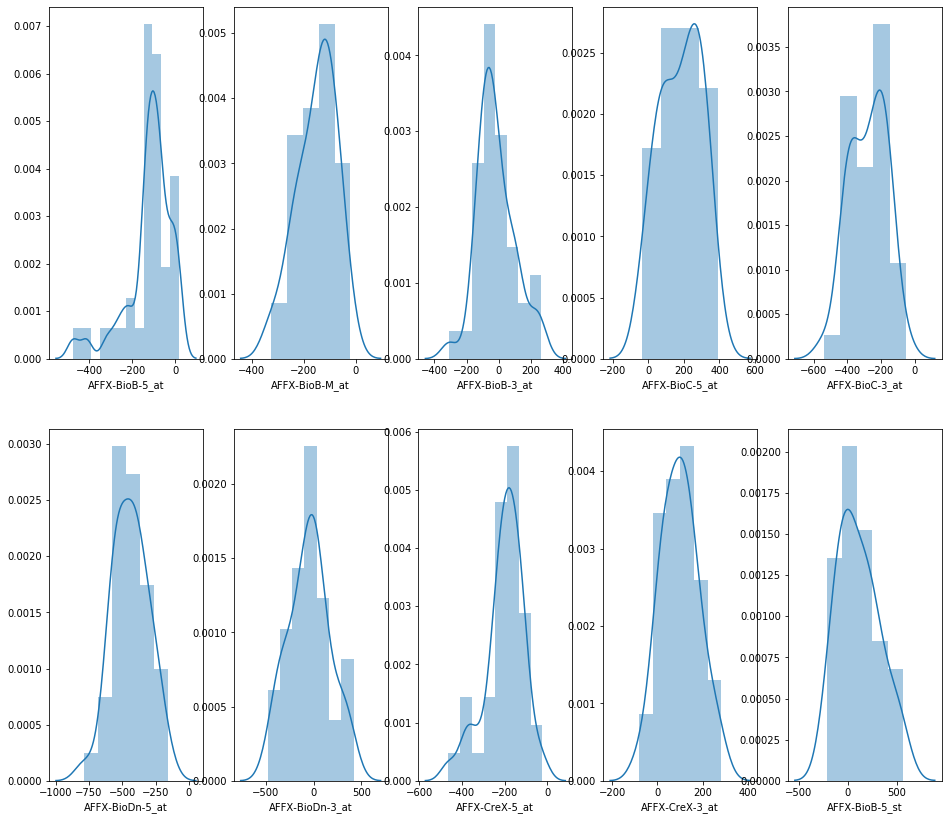

In [288]:
def distributionPlot(data, columnNumber):
    """ 
    Generates the distribution plot for the given data.

    Parameters:
        data: dataframe with the data to plot.
        columNumber: Number of columns the plot will return.

    """
    data_columns = data.columns.values 
    #data_columns = data._get_numeric_data().columns.values
    plot_columns = columnNumber
    number_of_columns = math.ceil(len(data_columns)/plot_columns)
    number_of_rows = math.ceil((len(data_columns))/number_of_columns)

    plt.figure(figsize=(16,22))

    # plot distribution
    for i in range(0, len(data_columns)):
        plt.subplot(number_of_columns + 1, number_of_rows, i+1)
        sns.distplot(data[data_columns[i]], kde=True) 

distributionPlot(train_slice, 5)

In [26]:
train_features = clean_train_labels.drop(['cancer', 'patient'], axis = 1)
train_labels = clean_train_labels['cancer']

test_features = clean_test_labels.drop(['cancer', 'patient'], axis = 1)
test_labels = clean_test_labels['cancer']


In [27]:
scaler = preprocessing.StandardScaler()

#### Create features and labels

In [30]:
scaled_train_fit = scaler.fit_transform(train_features)
scaled_test_fit = scaler.fit_transform(test_features)

In [31]:
column_names = list(train_features.columns) 

In [33]:
scaled_train = pd.DataFrame(scaled_train_fit, columns=column_names)
scaled_test = pd.DataFrame(scaled_test_fit, columns=column_names)

In [34]:
scaled_train.to_csv('golub_cancer_train_scaled.csv', index = False, header=True)
scaled_test.to_csv('golub_cancer_test_scaled.csv', index = False, header=True)


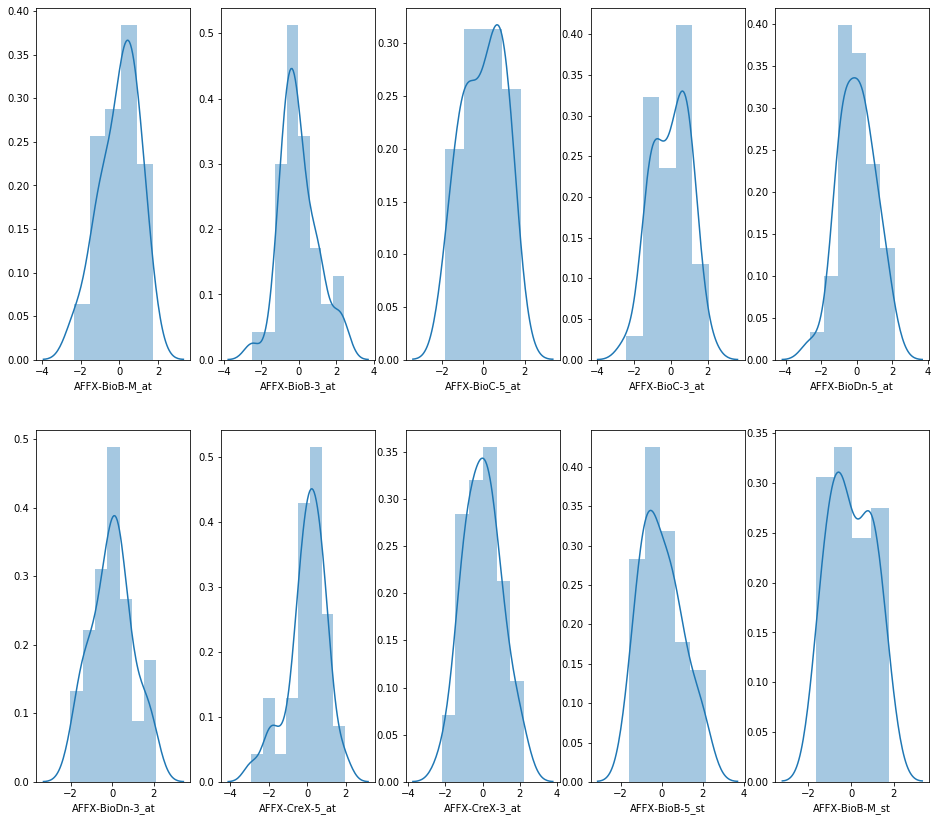

In [289]:
#Check skewness again

train_slice_s = scaled_train.iloc[:,1:11]
distributionPlot(train_slice_s, 5)

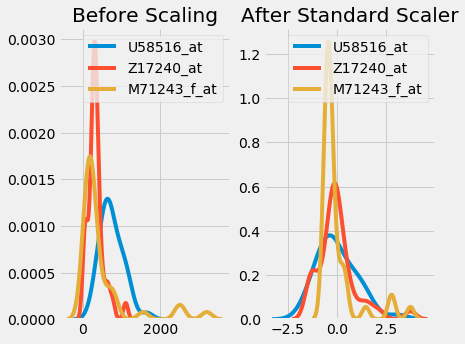

In [671]:
#Comparison before & after scaling 

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))

ax1.set_title('Before Scaling')
sns.kdeplot(train_features['U58516_at'], ax=ax1)
sns.kdeplot(train_features['Z17240_at'], ax=ax1)
sns.kdeplot(train_features['M71243_f_at'], ax=ax1)
ax2.set_title('After Standard Scaler')
sns.kdeplot(scaled_train['U58516_at'], ax=ax2)
sns.kdeplot(scaled_train['Z17240_at'], ax=ax2)
sns.kdeplot(scaled_train['M71243_f_at'], ax=ax2)
plt.show()

## Reload scaled data

In [246]:
scaled_train=pd.read_csv("golub_cancer_train_scaled.csv")
scaled_test=pd.read_csv("golub_cancer_test_scaled.csv")
scaled_train.columns

Index(['AFFX-BioB-5_at', 'AFFX-BioB-M_at', 'AFFX-BioB-3_at', 'AFFX-BioC-5_at',
       'AFFX-BioC-3_at', 'AFFX-BioDn-5_at', 'AFFX-BioDn-3_at',
       'AFFX-CreX-5_at', 'AFFX-CreX-3_at', 'AFFX-BioB-5_st',
       ...
       'U48730_at', 'U58516_at', 'U73738_at', 'X06956_at', 'X16699_at',
       'X83863_at', 'Z17240_at', 'L49218_f_at', 'M71243_f_at', 'Z78285_f_at'],
      dtype='object', length=7129)

In [383]:
l_list = labels.patient.tolist()
#l_list

## Build baseline models for baseline scores: Logistic Regression & Random Forest

### Baseline Logistic Regression

In [56]:
clf_0 = LogisticRegression(dual=False, max_iter=1000).fit(scaled_train, train_labels)
y_pred_clf_0 = clf_0.predict(scaled_test)


In [57]:
clf_0_cv_scores = cross_val_score(clf_0, scaled_train, train_labels, cv=5)
clf_0_cv_scores

array([0.875     , 1.        , 1.        , 0.85714286, 1.        ])

In [58]:
# Model Evaluation metrics 
accuracy_clf = (accuracy_score(test_labels,y_pred_clf_0))
print('Accuracy Score : ' + str(accuracy_score(test_labels,y_pred_clf_0)))
print('Precision Score : ' + str(precision_score(test_labels,y_pred_clf_0)))
print('Recall Score : ' + str(recall_score(test_labels,y_pred_clf_0)))
print('F1 Score : ' + str(f1_score(test_labels,y_pred_clf_0)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,y_pred_clf_0)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.7647058823529411
Precision Score : 0.7142857142857143
Recall Score : 1.0
F1 Score : 0.8333333333333333
Confusion Matrix CLF : 
[[ 6  8]
 [ 0 20]]


In [674]:
#Comparison between the actual test labels and labels predicted by the model.
ys = 1*(test_labels == y_pred_clf_0)
ys


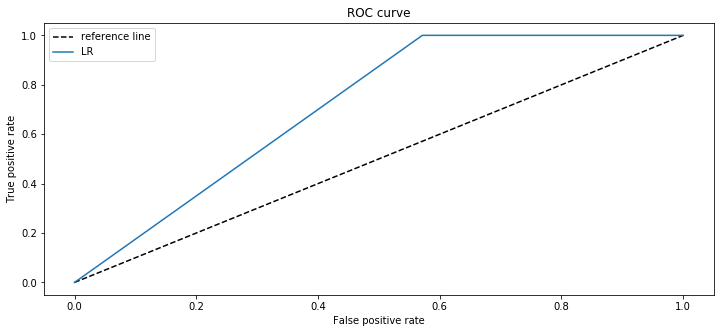

0.7142857142857143


In [62]:
AUC_score = roc_curve_plot(test_labels, y_pred_clf_0, legend = 'LR')
print(AUC_score)

In [675]:
#Try weighted per class
clf_weight = LogisticRegression(random_state=0, class_weight='balanced').fit(scaled_train, train_labels)

In [676]:
y_pred_weight = clf_weight.predict(scaled_test)


In [677]:
print('Accuracy Score : ' + str(accuracy_score(test_labels,y_pred_weight)))
print('Precision Score : ' + str(precision_score(test_labels,y_pred_weight)))
print('Recall Score : ' + str(recall_score(test_labels,y_pred_weight)))
print('F1 Score : ' + str(f1_score(test_labels,y_pred_weight)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,y_pred_weight)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.8235294117647058
Precision Score : 0.7692307692307693
Recall Score : 1.0
F1 Score : 0.8695652173913044
Confusion Matrix CLF : 
[[ 8  6]
 [ 0 20]]


In [1]:
#ys = 1*(test_labels == y_pred_weight)
#ys

### Baseline Random Forest

In [63]:
#scaled_train, train_labels
#scaled_test, test_labels

In [64]:
#Random forest classification.
classifier_forest_0 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_forest_0.fit(scaled_train, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [66]:
rf_0_cv_scores = cross_val_score(classifier_forest_0, scaled_train, train_labels, cv=5)
rf_0_cv_scores

array([0.875     , 1.        , 0.625     , 0.85714286, 0.85714286])

In [69]:
# Model Evaluation metrics 
y_pred_rf_0 = classifier_forest_0.predict(scaled_test)

accuracy_clf = (accuracy_score(test_labels,y_pred_rf_0))
print('Accuracy Score : ' + str(accuracy_score(test_labels,y_pred_rf_0)))
print('Precision Score : ' + str(precision_score(test_labels,y_pred_rf_0)))
print('Recall Score : ' + str(recall_score(test_labels,y_pred_rf_0)))
print('F1 Score : ' + str(f1_score(test_labels,y_pred_rf_0)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,y_pred_rf_0)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.8823529411764706
Precision Score : 0.8333333333333334
Recall Score : 1.0
F1 Score : 0.9090909090909091
Confusion Matrix CLF : 
[[10  4]
 [ 0 20]]


In [2]:
#ys = 1*(test_labels == y_pred_rf_0)
#ys

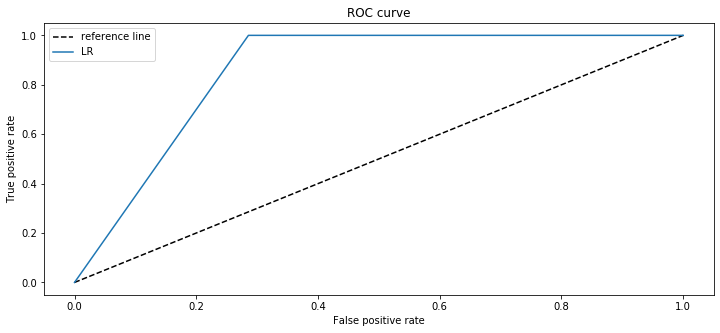

0.8571428571428572


In [71]:
AUC_score = roc_curve_plot(test_labels, y_pred_rf_0, legend = 'LR')
print(AUC_score)

### Are some features (genes) correlated?

In [36]:
len(scaled_train.columns)
#I have 7129 columns - features! 

7129

In [293]:
corr = train_slice_s.corr()


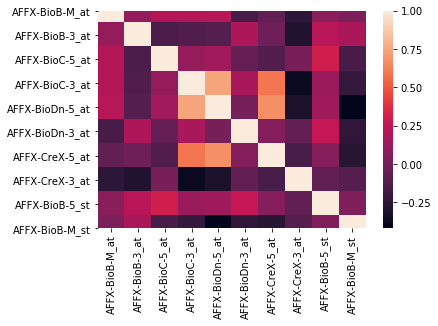

In [294]:
sns.heatmap(corr)


In [296]:
#Let's look at the correlation map for the features in our dataset.
corr_data= train_slice_s
corr_2 = corr_data.corr()
corr_2.style.background_gradient(cmap='coolwarm')


,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st
AFFX-BioB-M_at,1,0.111541,0.211543,0.213577,0.2211,-0.148462,-0.0625805,-0.251531,0.0732407,0.0310058
AFFX-BioB-3_at,0.111541,1,-0.132363,-0.123053,-0.103113,0.1902,-0.0156216,-0.291823,0.229361,0.182424
AFFX-BioC-5_at,0.211543,-0.132363,1,0.1099,0.147325,-0.0422189,-0.123357,0.0172611,0.309857,-0.147076
AFFX-BioC-3_at,0.213577,-0.123053,0.1099,1,0.743706,0.173812,0.591401,-0.380414,0.127128,-0.221726
AFFX-BioDn-5_at,0.2211,-0.103113,0.147325,0.743706,1,0.00988818,0.668825,-0.314451,0.138903,-0.417833
AFFX-BioDn-3_at,-0.148462,0.1902,-0.0422189,0.173812,0.00988818,1,0.0535902,-0.0569741,0.266661,-0.237007
AFFX-CreX-5_at,-0.0625805,-0.0156216,-0.123357,0.591401,0.668825,0.0535902,1,-0.142423,0.0615825,-0.272952
AFFX-CreX-3_at,-0.251531,-0.291823,0.0172611,-0.380414,-0.314451,-0.0569741,-0.142423,1,-0.0605956,-0.100957
AFFX-BioB-5_st,0.0732407,0.229361,0.309857,0.127128,0.138903,0.266661,0.0615825,-0.0605956,1,0.0392715
AFFX-BioB-M_st,0.0310058,0.182424,-0.147076,-0.221726,-0.417833,-0.237007,-0.272952,-0.100957,0.0392715,1


In [37]:
#Check for correlated features: 
#https://towardsdatascience.com/feature-selection-in-python-recursive-feature-elimination-19f1c39b8d15

correlated_features = set()
correlation_matrix = scaled_train.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [38]:
len(correlated_features)

1482

In [39]:
#Let's remove the correlated features first. NB did this after I started to look at the feature scores
scaled_train_drop = scaled_train.drop(correlated_features, axis=1)
scaled_test_drop = scaled_test.drop(correlated_features, axis=1)

### Logistic Regression and Random Forest after dropping correlated features (1482)

In [72]:
clf_drop = LogisticRegression(dual=False, max_iter=1000).fit(scaled_train_drop, train_labels)
y_pred_clf_drop = clf_drop.predict(scaled_test_drop)

In [73]:
clf_drop_cv_scores = cross_val_score(clf_drop, scaled_train_drop, train_labels, cv=5)
clf_drop_cv_scores

array([0.875     , 1.        , 0.875     , 0.85714286, 1.        ])

In [75]:
# Model Evaluation metrics 
accuracy_clf_drop = (accuracy_score(test_labels,y_pred_clf_drop))
print('Accuracy Score : ' + str(accuracy_score(test_labels,y_pred_clf_drop)))
print('Precision Score : ' + str(precision_score(test_labels,y_pred_clf_drop)))
print('Recall Score : ' + str(recall_score(test_labels,y_pred_clf_drop)))
print('F1 Score : ' + str(f1_score(test_labels,y_pred_clf_drop)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,y_pred_clf_drop)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.7352941176470589
Precision Score : 0.6896551724137931
Recall Score : 1.0
F1 Score : 0.8163265306122449
Confusion Matrix CLF : 
[[ 5  9]
 [ 0 20]]


In [3]:
#1*(test_labels == y_pred_clf_drop)


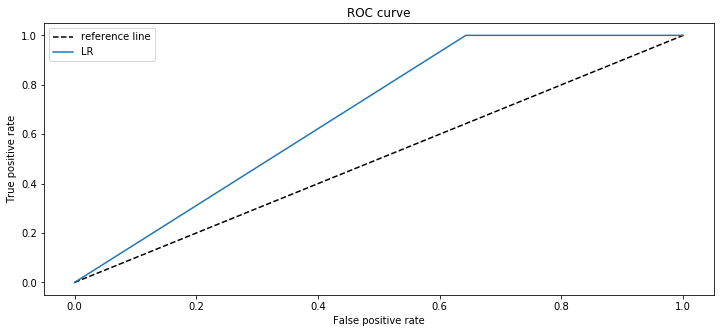

0.6785714285714286


In [76]:
AUC_score = roc_curve_plot(test_labels, y_pred_clf_drop, legend = 'LR')
print(AUC_score)

In [77]:
#Random forest classification.
classifier_forest_drop = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_forest_drop.fit(scaled_train_drop, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [78]:
rf_drop_cv_scores = cross_val_score(classifier_forest_0, scaled_train_drop, train_labels, cv=5)
rf_drop_cv_scores

array([0.75      , 0.875     , 0.75      , 0.85714286, 1.        ])

In [79]:
# Model Evaluation metrics 
y_pred_rf_drop = classifier_forest_drop.predict(scaled_test_drop)

accuracy_clf = (accuracy_score(test_labels,y_pred_rf_drop))
print('Accuracy Score : ' + str(accuracy_score(test_labels,y_pred_rf_drop)))
print('Precision Score : ' + str(precision_score(test_labels,y_pred_rf_drop)))
print('Recall Score : ' + str(recall_score(test_labels,y_pred_rf_drop)))
print('F1 Score : ' + str(f1_score(test_labels,y_pred_rf_drop)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,y_pred_rf_drop)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.7352941176470589
Precision Score : 0.7037037037037037
Recall Score : 0.95
F1 Score : 0.8085106382978724
Confusion Matrix CLF : 
[[ 6  8]
 [ 1 19]]


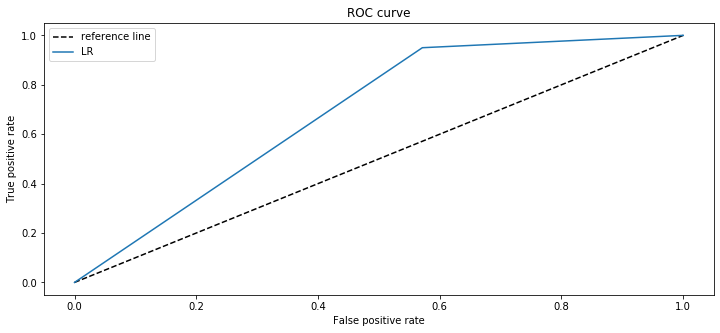

0.6892857142857143


In [80]:
AUC_score = roc_curve_plot(test_labels, y_pred_rf_drop, legend = 'LR')
print(AUC_score)

## Recursive Feature Elimination (based on RandomForest)

In [145]:
#scaled_train, train_labels
#scaled_test, test_labels

In [385]:
X = scaled_train
target = train_labels

rfc = RandomForestClassifier()
rfecv = RFE(estimator=rfc, step=100, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X, target)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=100,
      verbose=0)

In [386]:
print('Optimal number of features: {}'.format(rfecv.n_features_))


Optimal number of features: 3329


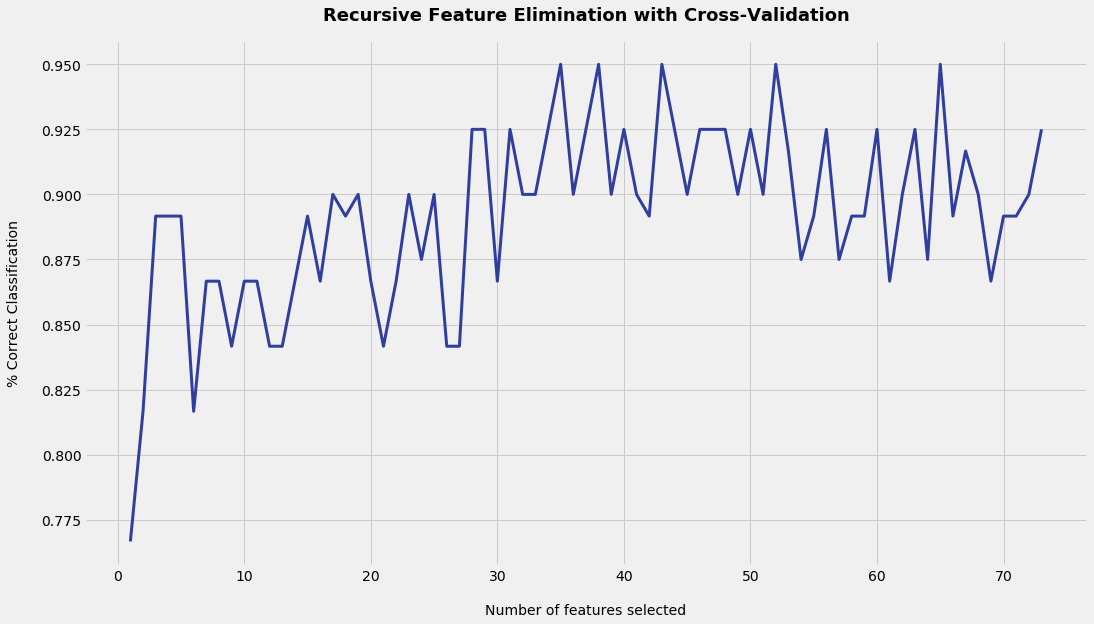

In [387]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [388]:
scaled_train.columns

Index(['AFFX-BioB-5_at', 'AFFX-BioB-M_at', 'AFFX-BioB-3_at', 'AFFX-BioC-5_at',
       'AFFX-BioC-3_at', 'AFFX-BioDn-5_at', 'AFFX-BioDn-3_at',
       'AFFX-CreX-5_at', 'AFFX-CreX-3_at', 'AFFX-BioB-5_st',
       ...
       'U48730_at', 'U58516_at', 'U73738_at', 'X06956_at', 'X16699_at',
       'X83863_at', 'Z17240_at', 'L49218_f_at', 'M71243_f_at', 'Z78285_f_at'],
      dtype='object', length=7129)

In [389]:
names = scaled_train.columns
#print ("Features sorted by their rank:")
#print (sorted(zip(map(lambda x: round(x, 4), rfecv.ranking_), names)))
rfecv_features = sorted(zip(map(lambda x: round(x, 4), rfecv.ranking_), names))
(rfecv_features[2229][1]) #get feature names

'M32315_at'

In [164]:
#get the 300 features

In [408]:
rfecv_count = 0
rfecv_list = []
while rfecv_count < 300:
    rfecv_list.append((rfecv_features[rfecv_count][1]))
    rfecv_count += 1 
    


300 AB002380_at


In [557]:
print(len(rfecv_list), rfecv_list[25])   

300 AB002380_at


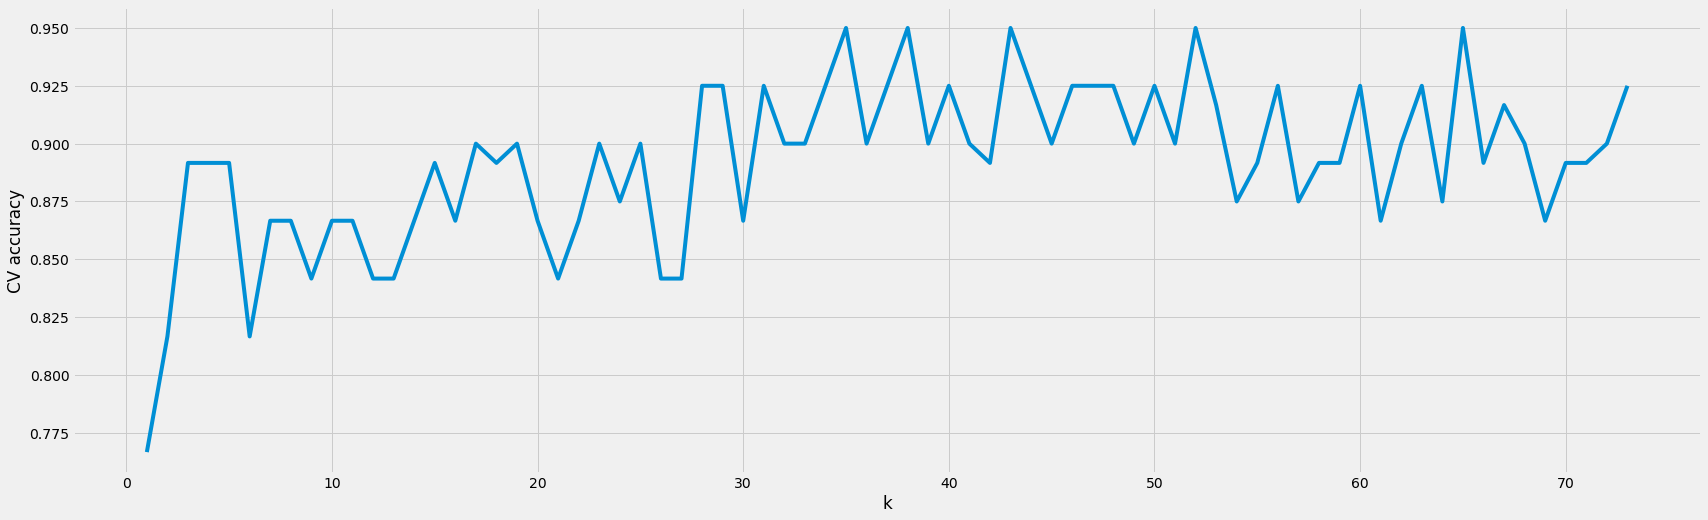

In [391]:
plt.figure(figsize=(26,8))
plt.xlabel('k')
plt.ylabel('CV accuracy')
plt.plot(np.arange(1, rfecv.grid_scores_.size+1), rfecv.grid_scores_)
plt.show()

In [392]:
print('Number of features selected: {}'.format(rfecv.n_features_))

Number of features selected: 3329


In [393]:
rfecv.grid_scores_

array([0.76666667, 0.81666667, 0.89166667, 0.89166667, 0.89166667,
       0.81666667, 0.86666667, 0.86666667, 0.84166667, 0.86666667,
       0.86666667, 0.84166667, 0.84166667, 0.86666667, 0.89166667,
       0.86666667, 0.9       , 0.89166667, 0.9       , 0.86666667,
       0.84166667, 0.86666667, 0.9       , 0.875     , 0.9       ,
       0.84166667, 0.84166667, 0.925     , 0.925     , 0.86666667,
       0.925     , 0.9       , 0.9       , 0.925     , 0.95      ,
       0.9       , 0.925     , 0.95      , 0.9       , 0.925     ,
       0.9       , 0.89166667, 0.95      , 0.925     , 0.9       ,
       0.925     , 0.925     , 0.925     , 0.9       , 0.925     ,
       0.9       , 0.95      , 0.91666667, 0.875     , 0.89166667,
       0.925     , 0.875     , 0.89166667, 0.89166667, 0.925     ,
       0.86666667, 0.9       , 0.925     , 0.875     , 0.95      ,
       0.89166667, 0.91666667, 0.9       , 0.86666667, 0.89166667,
       0.89166667, 0.9       , 0.925     ])

In [ ]:
dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

#### New dataset with the rfecv_list 300 features

In [395]:
#scaled_train, train_labels
#scaled_test, test_labels

#List of features: rfecv_list

rfecv_train = scaled_train[rfecv_list]
#len(rfecv_train.columns)
rfecv_test = scaled_test[rfecv_list]
rfecv_test.head()

,A28102_at,AB000114_at,AB000115_at,AB000220_at,AB000409_at,AB000449_at,AB000450_at,AB000460_at,AB000462_at,AB000464_at,...,D26579_at,D26598_at,D26599_at,D26600_at,D28114_at,D28118_at,D28124_at,D28137_at,D28364_at,D28383_at
0,-0.206400,-0.883348,-0.084775,0.865569,-1.355930,-0.201483,0.744936,1.311560,0.112535,1.653376,...,-0.332397,-0.079714,0.059824,-0.232492,2.649178,-0.008068,-0.434885,-0.893518,-0.426937,0.952705
1,0.765267,-0.347713,-0.484178,0.287389,0.651457,-0.701190,1.915287,0.342526,-0.520315,1.227631,...,-0.134723,-0.197264,0.689777,-0.725796,0.966175,0.734476,1.114572,-0.343699,0.292243,-1.125021
2,-0.103578,0.175169,-0.510805,-0.040246,0.396551,1.088901,0.601992,1.271846,3.007644,-1.523341,...,-0.959500,0.205056,0.701626,0.481814,-0.999421,0.261518,-0.581766,-0.413484,-0.336007,-0.266032
3,-0.951858,-0.003376,-0.460879,-0.252245,-0.718665,0.646122,-0.702368,-1.057014,-0.302091,-0.380378,...,-0.622091,-0.256867,-0.858447,0.505492,-0.584951,0.445972,-0.299523,-0.421943,0.300509,0.115741
4,1.407903,1.743816,-0.424267,-0.425699,0.437518,1.209084,-0.621962,-1.371553,0.163454,-0.629275,...,-1.221929,-0.417464,-0.611600,-0.408108,-0.854985,-0.594536,-0.192962,-0.732802,-1.418910,-0.779957


### Models after the Recursive Feature Elimination

In [396]:
clf_rfecv = LogisticRegression(dual=False, max_iter=1000).fit(rfecv_train, train_labels)
y_pred_clf_rfecv = clf_rfecv.predict(rfecv_test)

In [397]:
clf_rfecv_cv_scores = cross_val_score(clf_rfecv, rfecv_train, train_labels, cv=5)
clf_rfecv_cv_scores

array([0.875, 1.   , 0.875, 1.   , 1.   ])

In [398]:
# Model Evaluation metrics 

accuracy_clf = (accuracy_score(test_labels,y_pred_clf_rfecv))
print('Accuracy Score : ' + str(accuracy_score(test_labels,y_pred_clf_rfecv)))
print('Precision Score : ' + str(precision_score(test_labels,y_pred_clf_rfecv)))
print('Recall Score : ' + str(recall_score(test_labels,y_pred_clf_rfecv)))
print('F1 Score : ' + str(f1_score(test_labels,y_pred_clf_rfecv)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,y_pred_clf_rfecv)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.7058823529411765
Precision Score : 0.6666666666666666
Recall Score : 1.0
F1 Score : 0.8
Confusion Matrix CLF : 
[[ 4 10]
 [ 0 20]]


In [4]:
#ys = 1*(test_labels == y_pred_clf_rfecv)
#ys

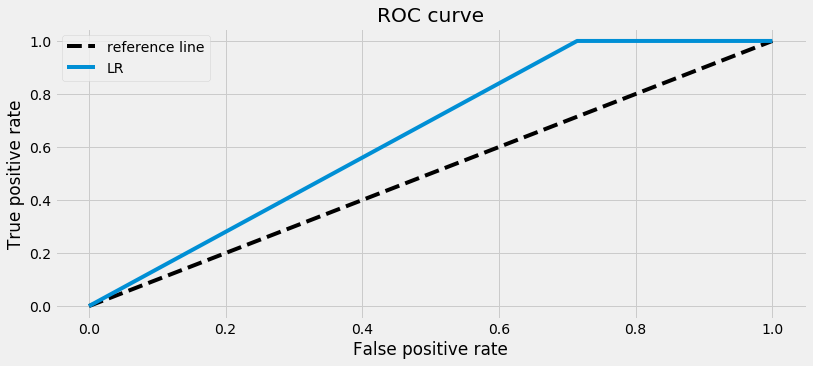

0.6428571428571428


In [399]:
AUC_score = roc_curve_plot(test_labels, y_pred_clf_rfecv, legend = 'LR')
print(AUC_score)

In [400]:
#rfecv_train 
#rfecv_test

#Random forest classification.

classifier_forest_rfecv = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_forest_rfecv.fit(rfecv_train, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [401]:
rf_rfecv_cv_scores = cross_val_score(classifier_forest_rfecv, rfecv_train, train_labels, cv=5)
rf_rfecv_cv_scores

array([0.875     , 0.75      , 0.875     , 0.85714286, 0.85714286])

In [402]:
# Model Evaluation metrics 
y_pred_rfecv = classifier_forest_rfecv.predict(rfecv_test)

accuracy_clf = (accuracy_score(test_labels,y_pred_rfecv))
print('Accuracy Score : ' + str(accuracy_score(test_labels,y_pred_rfecv)))
print('Precision Score : ' + str(precision_score(test_labels,y_pred_rfecv)))
print('Recall Score : ' + str(recall_score(test_labels,y_pred_rfecv)))
print('F1 Score : ' + str(f1_score(test_labels,y_pred_rfecv)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,y_pred_rfecv)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.7352941176470589
Precision Score : 0.72
Recall Score : 0.9
F1 Score : 0.7999999999999999
Confusion Matrix CLF : 
[[ 7  7]
 [ 2 18]]


In [5]:
#ys = 1*(test_labels == y_pred_rfecv)
#ys

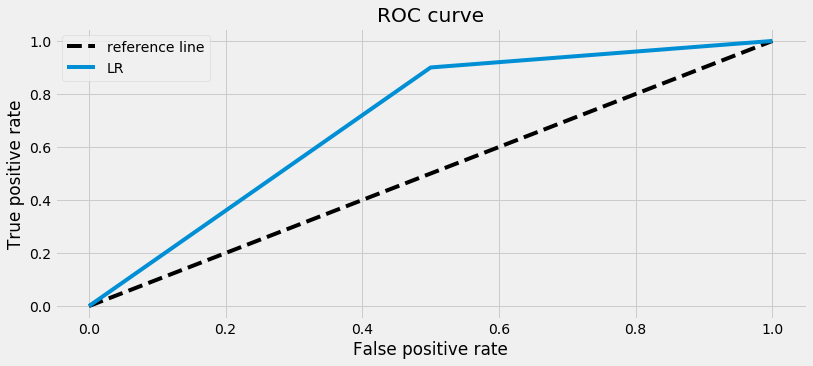

0.7


In [403]:
AUC_score = roc_curve_plot(test_labels, y_pred_rfecv, legend = 'LR')
print(AUC_score)

In [404]:
## The same, but using 50 best

In [413]:
rfecv_count_50 = 0
rfecv_list_50 = []
while rfecv_count_50 < 50:
    rfecv_list_50.append((rfecv_features[rfecv_count_50][1]))
    rfecv_count_50 += 1 
    
print(len(rfecv_list_50), rfecv_list_50[0])  

50 A28102_at


In [414]:
#scaled_train, train_labels
#scaled_test, test_labels

#List of features: rfecv_list

rfecv_train_50 = scaled_train[rfecv_list_50]
#len(rfecv_train.columns)
rfecv_test_50 = scaled_test[rfecv_list_50]
rfecv_test_50.head()

,A28102_at,AB000114_at,AB000115_at,AB000220_at,AB000409_at,AB000449_at,AB000450_at,AB000460_at,AB000462_at,AB000464_at,...,AC000066_at,AC000099_at,AC000115_cds1_at,AC002045_xpt1_at,AC002073_cds1_at,AC002076_cds2_at,AC002077_at,AC002086_at,AC002115_cds1_at,AC002115_cds3_at
0,-0.206400,-0.883348,-0.084775,0.865569,-1.355930,-0.201483,0.744936,1.311560,0.112535,1.653376,...,-1.133714,1.421750,0.673079,-0.722655,-0.045184,-0.855478,1.154354,1.422321,0.017155,2.266711
1,0.765267,-0.347713,-0.484178,0.287389,0.651457,-0.701190,1.915287,0.342526,-0.520315,1.227631,...,-1.418364,1.445244,-0.926871,0.737070,-1.041538,-0.083461,0.960008,0.677162,-0.501719,-0.734998
2,-0.103578,0.175169,-0.510805,-0.040246,0.396551,1.088901,0.601992,1.271846,3.007644,-1.523341,...,-1.109993,0.223541,-0.819009,-0.573486,-1.208415,-1.147593,-0.081491,-0.335490,0.177470,-0.566678
3,-0.951858,-0.003376,-0.460879,-0.252245,-0.718665,0.646122,-0.702368,-1.057014,-0.302091,-0.380378,...,0.170929,0.282277,0.601171,0.193669,0.254213,0.500768,0.446733,0.333242,-0.653444,-0.482518
4,1.407903,1.743816,-0.424267,-0.425699,0.437518,1.209084,-0.621962,-1.371553,0.163454,-0.629275,...,1.285806,-0.704483,-1.160572,-0.903789,0.342560,-3.672296,-0.270854,0.963762,-0.186100,-0.331030


In [415]:
clf_rfecv_50 = LogisticRegression(dual=False, max_iter=1000).fit(rfecv_train_50, train_labels)
y_pred_clf_rfecv_50 = clf_rfecv_50.predict(rfecv_test_50)

In [416]:
clf_rfecv_cv_scores = cross_val_score(clf_rfecv_50, rfecv_train_50, train_labels, cv=5)
clf_rfecv_cv_scores

array([0.75      , 0.625     , 0.625     , 0.71428571, 0.85714286])

In [417]:
# Model Evaluation metrics 

print('Accuracy Score : ' + str(accuracy_score(test_labels,y_pred_clf_rfecv_50)))
print('Precision Score : ' + str(precision_score(test_labels,y_pred_clf_rfecv_50)))
print('Recall Score : ' + str(recall_score(test_labels,y_pred_clf_rfecv_50)))
print('F1 Score : ' + str(f1_score(test_labels,y_pred_clf_rfecv_50)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,y_pred_clf_rfecv_50)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.7647058823529411
Precision Score : 0.7307692307692307
Recall Score : 0.95
F1 Score : 0.8260869565217392
Confusion Matrix CLF : 
[[ 7  7]
 [ 1 19]]


In [6]:
#ys = 1*(test_labels == y_pred_clf_rfecv_50)
#ys

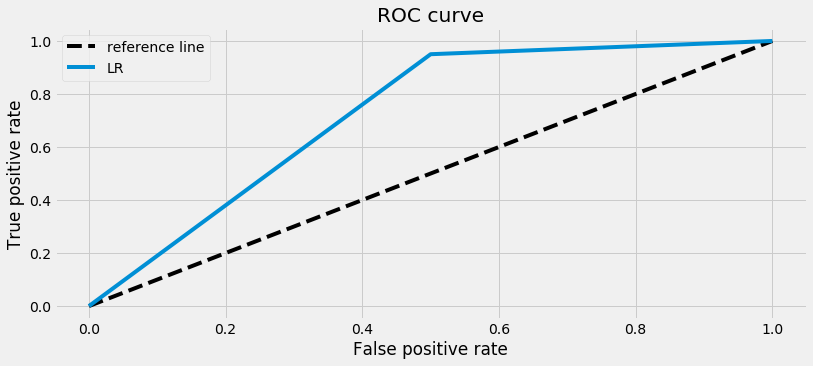

0.725


In [418]:
AUC_score = roc_curve_plot(test_labels, y_pred_clf_rfecv_50, legend = 'LR')
print(AUC_score)

In [419]:
#Random forest classification.

classifier_forest_rfecv_50 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_forest_rfecv_50.fit(rfecv_train_50, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [420]:
rf_rfecv_cv_scores = cross_val_score(classifier_forest_rfecv_50, rfecv_train_50, train_labels, cv=5)
rf_rfecv_cv_scores

array([0.625     , 0.625     , 0.75      , 0.71428571, 0.57142857])

In [421]:
# Model Evaluation metrics 
y_pred_rfecv_50 = classifier_forest_rfecv_50.predict(rfecv_test_50)

print('Accuracy Score : ' + str(accuracy_score(test_labels,y_pred_rfecv_50)))
print('Precision Score : ' + str(precision_score(test_labels,y_pred_rfecv_50)))
print('Recall Score : ' + str(recall_score(test_labels,y_pred_rfecv_50)))
print('F1 Score : ' + str(f1_score(test_labels,y_pred_rfecv_50)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,y_pred_rfecv_50)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.6764705882352942
Precision Score : 0.6551724137931034
Recall Score : 0.95
F1 Score : 0.7755102040816326
Confusion Matrix CLF : 
[[ 4 10]
 [ 1 19]]


In [7]:
#ys = 1*(test_labels == y_pred_rfecv_50)
#ys

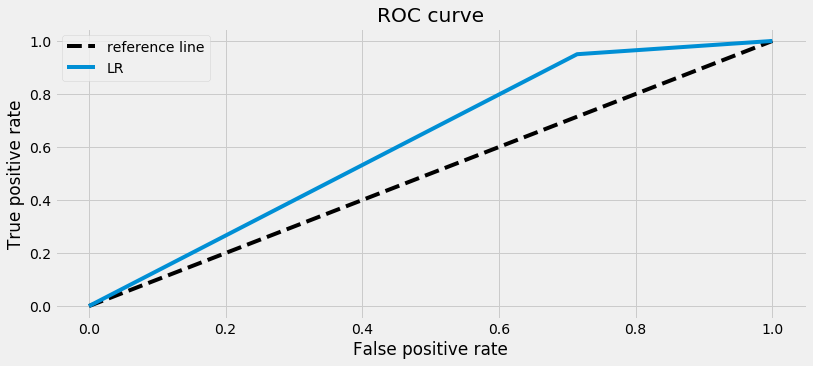

0.6178571428571429


In [422]:
AUC_score = roc_curve_plot(test_labels, y_pred_rfecv_50, legend = 'LR')
print(AUC_score)

### another version of RFE:
https://dkopczyk.quantee.co.uk/feature-selection/

In [137]:
#Starting data
#scaled_train, train_labels
#scaled_test, test_labels

Number of features selected: 40
Test Accuracy 0.7647058823529411


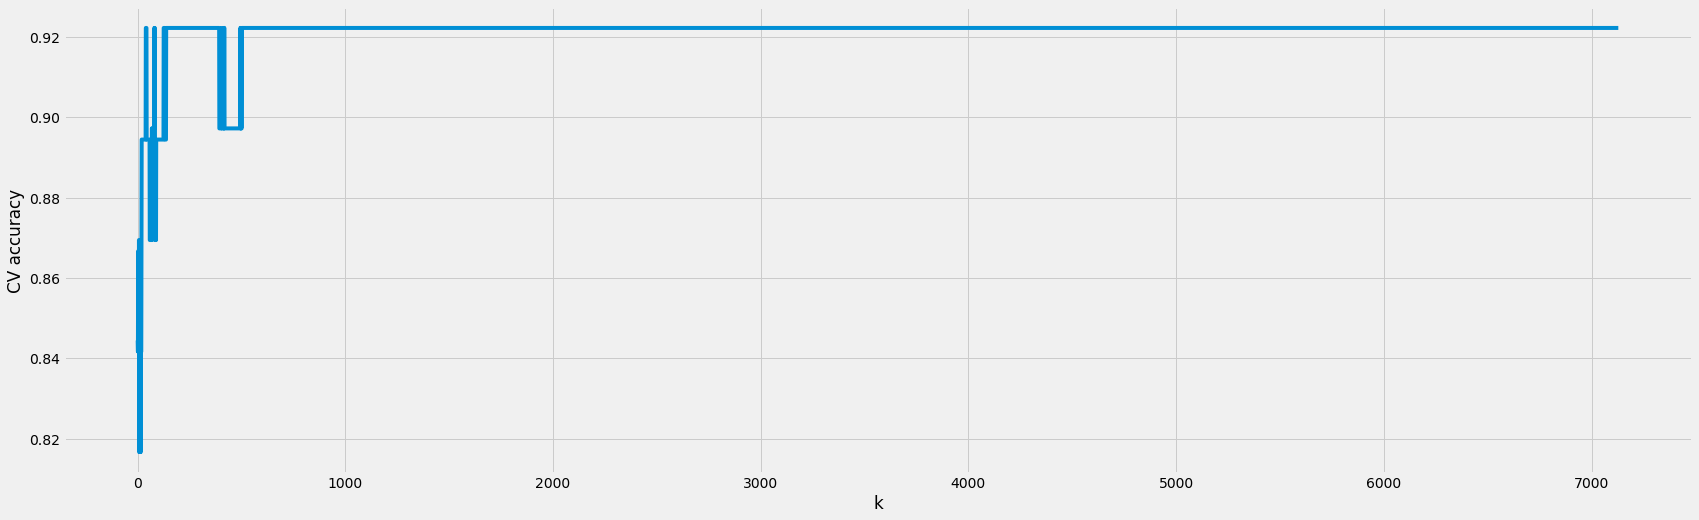

In [424]:

from sklearn.feature_selection import RFECV
 
# RFE
#rfe_2 = RFECV(estimator=LogisticRegression(), cv=4, scoring='accuracy')
#rfe_2 = rfe_2.fit(scaled_train, train_labels)
 
# Select variables and calulate test accuracy
cols = scaled_train.columns[rfe_2.support_]
acc = accuracy_score(test_labels, rfe_2.estimator_.predict(scaled_test[cols]))
print('Number of features selected: {}'.format(rfe_2.n_features_))
print('Test Accuracy {}'.format(acc))
 
# Plot number of features vs CV scores
plt.figure(figsize=(26,8))
plt.xlabel('k')
plt.ylabel('CV accuracy')
plt.plot(np.arange(1, rfe_2.grid_scores_.size+1), rfe_2.grid_scores_)
plt.show()

In [425]:
rfe_2_features = sorted(zip(map(lambda x: round(x, 4), rfe_2.ranking_), names))
(rfe_2_features[0])

(1, 'D21851_at')

In [440]:
#create the 300 set
rfe_2_count = 0
rfe_2_list = []
while rfe_2_count < 300:
    rfe_2_list.append((rfe_2_features[rfe_2_count][1]))
    rfe_2_count += 1 
    
print(len(rfe_2_list), rfe_2_list[10])  

300 M37435_at


#### New dataset with the rfecv_list 300 features

In [427]:
#scaled_train, train_labels
#scaled_test, test_labels

#List of features: rfe_2_list

rfecv_train_2 = scaled_train[rfe_2_list]
#len(rfecv_train.columns)
rfecv_test_2 = scaled_test[rfe_2_list]
rfecv_test_2.head()

,D21851_at,D49950_at,L08246_at,M13690_s_at,M16038_at,M19507_at,M23197_at,M24400_at,M27891_at,M29610_s_at,...,U34044_at,U19878_at,U04520_at,HG537-HT537_at,L07758_at,M19309_s_at,U66061_cds3_at,L42379_at,L14856_at,L19437_at
0,0.306942,0.681601,-0.649146,-0.835979,-0.817569,-0.582850,-0.609756,1.442341,-0.631236,-0.253089,...,0.369912,0.514976,0.723478,-2.878398,-0.632130,-1.174962,1.306880,-0.269514,-0.034393,-1.136857
1,-0.114161,0.879927,-1.180085,0.555371,0.052473,-0.651214,-0.468484,0.528930,-0.612625,0.017040,...,-0.259510,-1.021167,-0.545747,-0.447864,0.623892,-0.692261,0.916408,-1.127733,0.675736,-0.715364
2,-0.425411,-1.480156,-0.683150,-1.198724,-0.368116,-0.642716,-0.786346,-1.380511,-0.639631,-0.393485,...,-0.042074,-1.248744,-0.837780,-0.236749,0.728925,-0.503379,-1.488543,-0.648861,-0.855081,-0.477331
3,-1.121146,-1.093420,-0.226781,-0.353976,-0.678747,-0.519559,-0.635780,-0.476280,-0.587158,3.039995,...,-0.888932,0.130940,-0.118928,0.813415,-0.282019,-0.246288,0.224208,-0.247878,-1.246290,-0.177757
4,-0.718352,-1.014089,-0.891350,-1.094373,-0.736475,-0.491148,-0.758464,-0.604800,-0.635573,1.271717,...,-1.175033,-0.366884,-1.916059,0.012259,-1.288587,-0.262029,-1.089197,0.105506,-0.850829,-0.089510


### Models after the 2nd Recursive Feature Elimination

In [428]:
clf_rfecv_2 = LogisticRegression(dual=False, max_iter=1000).fit(rfecv_train_2, train_labels)
y_pred_clf_rfecv_2 = clf_rfecv_2.predict(rfecv_test_2)

In [429]:
clf_rfecv_cv_scores_2 = cross_val_score(clf_rfecv_2, rfecv_train_2, train_labels, cv=5)
clf_rfecv_cv_scores_2

array([1., 1., 1., 1., 1.])

In [430]:
# Model Evaluation metrics 

accuracy_clf = (accuracy_score(test_labels,y_pred_clf_rfecv_2))
print('Accuracy Score : ' + str(accuracy_score(test_labels,y_pred_clf_rfecv_2)))
print('Precision Score : ' + str(precision_score(test_labels,y_pred_clf_rfecv_2)))
print('Recall Score : ' + str(recall_score(test_labels,y_pred_clf_rfecv_2)))
print('F1 Score : ' + str(f1_score(test_labels,y_pred_clf_rfecv_2)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,y_pred_clf_rfecv_2)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.7941176470588235
Precision Score : 0.7407407407407407
Recall Score : 1.0
F1 Score : 0.851063829787234
Confusion Matrix CLF : 
[[ 7  7]
 [ 0 20]]


In [8]:
#ys = 1*(test_labels == y_pred_clf_rfecv_2)
#ys

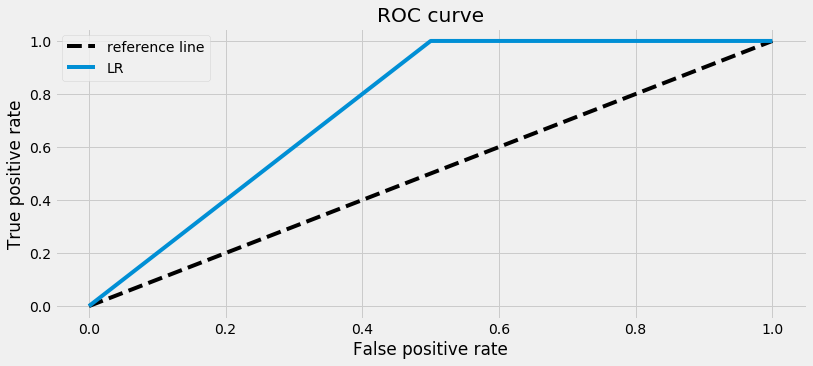

0.75


In [431]:
AUC_score = roc_curve_plot(test_labels, y_pred_clf_rfecv_2, legend = 'LR')
print(AUC_score)

In [432]:
#rfecv_train_2 
#rfecv_test_2

#Random forest classification.

classifier_forest_rfecv_2 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_forest_rfecv_2.fit(rfecv_train_2, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [433]:
rf_rfecv_cv_scores = cross_val_score(classifier_forest_rfecv_2, rfecv_train_2, train_labels, cv=5)
rf_rfecv_cv_scores

array([1.   , 1.   , 0.875, 1.   , 1.   ])

In [434]:
# Model Evaluation metrics 
y_pred_rfecv_2 = classifier_forest_rfecv_2.predict(rfecv_test_2)

accuracy_clf = (accuracy_score(test_labels,y_pred_rfecv_2))
print('Accuracy Score : ' + str(accuracy_score(test_labels,y_pred_rfecv_2)))
print('Precision Score : ' + str(precision_score(test_labels,y_pred_rfecv_2)))
print('Recall Score : ' + str(recall_score(test_labels,y_pred_rfecv_2)))
print('F1 Score : ' + str(f1_score(test_labels,y_pred_rfecv_2)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,y_pred_rfecv_2)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.8823529411764706
Precision Score : 0.8333333333333334
Recall Score : 1.0
F1 Score : 0.9090909090909091
Confusion Matrix CLF : 
[[10  4]
 [ 0 20]]


In [9]:
#ys = 1*(test_labels == y_pred_rfecv_2)
#ys

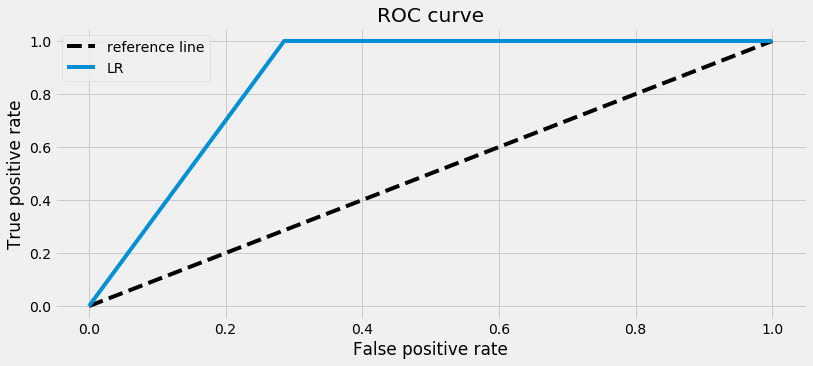

0.8571428571428572


In [435]:
AUC_score = roc_curve_plot(test_labels, y_pred_rfecv_2, legend = 'LR')
print(AUC_score)

In [437]:
# With the 50 features

In [441]:
rfe_2_count_50 = 0
rfe_2_list_50 = []
while rfe_2_count_50 < 50:
    rfe_2_list_50.append((rfe_2_features[rfe_2_count_50][1]))
    rfe_2_count_50 += 1 
    
print(len(rfe_2_list_50), rfe_2_list_50[10])  

50 M37435_at


In [442]:
rfecv_train_2_50 = scaled_train[rfe_2_list_50]
#len(rfecv_train.columns)
rfecv_test_2_50 = scaled_test[rfe_2_list_50]
rfecv_test_2_50.head()

,D21851_at,D49950_at,L08246_at,M13690_s_at,M16038_at,M19507_at,M23197_at,M24400_at,M27891_at,M29610_s_at,...,M61853_at,M63138_at,Y00339_s_at,S81439_at,X13839_at,M96326_rna1_at,U21689_at,M60298_at,HG2562-HT2658_s_at,U67963_at
0,0.306942,0.681601,-0.649146,-0.835979,-0.817569,-0.582850,-0.609756,1.442341,-0.631236,-0.253089,...,0.436462,-0.761633,-0.316947,-0.031175,-0.481542,-0.503695,-0.097829,-0.409868,1.523363,-0.617900
1,-0.114161,0.879927,-1.180085,0.555371,0.052473,-0.651214,-0.468484,0.528930,-0.612625,0.017040,...,1.897702,-0.742419,-0.360893,-0.816823,-0.291555,-0.475992,0.457101,-0.153369,-0.705035,-0.705018
2,-0.425411,-1.480156,-0.683150,-1.198724,-0.368116,-0.642716,-0.786346,-1.380511,-0.639631,-0.393485,...,-0.164270,-0.675001,-0.330322,-0.694913,-0.380960,-0.493721,1.232421,-0.266116,0.600169,-0.702840
3,-1.121146,-1.093420,-0.226781,-0.353976,-0.678747,-0.519559,-0.635780,-0.476280,-0.587158,3.039995,...,0.127978,-0.709047,3.756612,3.199466,-0.649177,-0.542894,-0.085397,5.047078,-0.227521,-0.123503
4,-0.718352,-1.014089,-0.891350,-1.094373,-0.736475,-0.491148,-0.758464,-0.604800,-0.635573,1.271717,...,1.995118,-0.575897,3.718398,-0.278383,-0.962097,-0.280962,-0.231193,1.971908,0.393247,-0.672349


In [443]:
clf_rfecv_2_50 = LogisticRegression(dual=False, max_iter=1000).fit(rfecv_train_2_50, train_labels)
y_pred_clf_rfecv_2_50 = clf_rfecv_2_50.predict(rfecv_test_2_50)

In [444]:
clf_rfecv_cv_scores_2 = cross_val_score(clf_rfecv_2_50, rfecv_train_2_50, train_labels, cv=5)
clf_rfecv_cv_scores_2

array([1., 1., 1., 1., 1.])

In [445]:
print('Accuracy Score : ' + str(accuracy_score(test_labels,y_pred_clf_rfecv_2_50)))
print('Precision Score : ' + str(precision_score(test_labels,y_pred_clf_rfecv_2_50)))
print('Recall Score : ' + str(recall_score(test_labels,y_pred_clf_rfecv_2_50)))
print('F1 Score : ' + str(f1_score(test_labels,y_pred_clf_rfecv_2_50)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,y_pred_clf_rfecv_2_50)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.7941176470588235
Precision Score : 0.7407407407407407
Recall Score : 1.0
F1 Score : 0.851063829787234
Confusion Matrix CLF : 
[[ 7  7]
 [ 0 20]]


In [10]:
#ys = 1*(test_labels == y_pred_clf_rfecv_2_50)
#ys

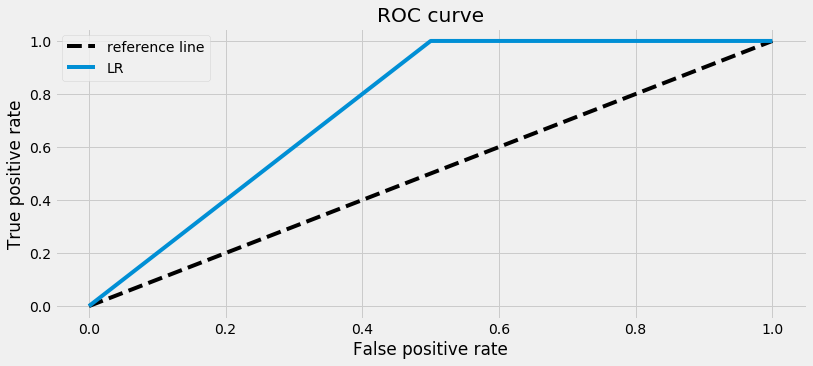

0.75


In [446]:
AUC_score = roc_curve_plot(test_labels, y_pred_clf_rfecv_2_50, legend = 'LR')
print(AUC_score)

In [447]:
classifier_forest_rfecv_2_50 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_forest_rfecv_2_50.fit(rfecv_train_2_50, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [448]:
rf_rfecv_cv_scores = cross_val_score(classifier_forest_rfecv_2_50, rfecv_train_2_50, train_labels, cv=5)
rf_rfecv_cv_scores

array([0.875, 1.   , 1.   , 1.   , 1.   ])

In [449]:
y_pred_rfecv_2_50 = classifier_forest_rfecv_2_50.predict(rfecv_test_2_50)

print('Accuracy Score : ' + str(accuracy_score(test_labels,y_pred_rfecv_2_50)))
print('Precision Score : ' + str(precision_score(test_labels,y_pred_rfecv_2_50)))
print('Recall Score : ' + str(recall_score(test_labels,y_pred_rfecv_2_50)))
print('F1 Score : ' + str(f1_score(test_labels,y_pred_rfecv_2_50)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,y_pred_rfecv_2_50)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.8823529411764706
Precision Score : 0.8333333333333334
Recall Score : 1.0
F1 Score : 0.9090909090909091
Confusion Matrix CLF : 
[[10  4]
 [ 0 20]]


In [11]:
#ys = 1*(test_labels == y_pred_rfecv_2_50)
#ys

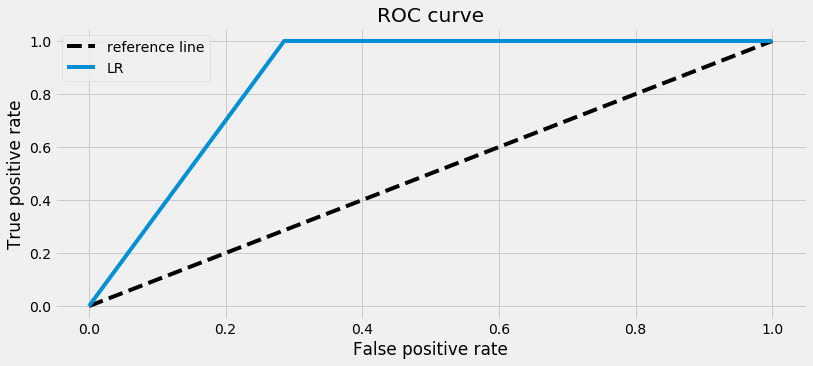

0.8571428571428572


In [450]:
AUC_score = roc_curve_plot(test_labels, y_pred_rfecv_2_50, legend = 'LR')
print(AUC_score)

### Methods to analyze the feature imortance: SelectKBest and feature_importance_ attribute of tree-based models

In [81]:
#scaled_train, train_labels
#scaled_test, test_labels

In [451]:
#scaled_train_drop
scaled_train.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,-0.861496,-0.033101,-0.351701,-0.805738,-0.168417,-0.888716,1.120068,0.280962,1.863470,0.449110,...,0.074511,-0.815620,-1.758717,-0.021865,-0.405584,-0.159782,-0.033046,0.546068,-0.435820,-0.255875
1,-0.167723,1.037400,0.139139,0.876572,0.114600,0.293351,-1.322502,0.370212,0.023726,-0.182439,...,-0.116640,0.292993,-0.589006,0.092516,0.073055,-0.182892,-0.197260,-0.267043,-0.595744,0.499648
2,0.415047,1.358550,-2.495899,1.100880,-0.907912,-1.577008,0.353591,-1.849884,1.303018,-1.565148,...,1.627617,1.524030,0.317849,-0.498816,1.724361,0.565043,2.130709,0.708690,-0.384366,-0.387270
3,-0.130721,0.488768,2.429729,-1.461407,-1.300484,-1.090715,0.930757,-0.578070,-0.609828,-0.388171,...,0.731595,0.286192,2.749271,-0.485868,-2.152617,-0.508538,-0.800986,-2.251033,-0.526212,-2.029712
4,0.137537,0.341574,-0.506703,-0.115559,0.425006,1.161198,0.219688,0.883400,-0.353970,0.669195,...,-0.271951,-0.346330,0.633277,0.226322,-0.142332,-1.300593,-0.105493,-0.169469,-0.623557,0.138311


In [466]:
#apply SelectKBest class to extract top best features
#The chi-square test measures dependence between stochastic variables, so using this function “weeds out” the features
#that are the most likely to be independent of class and therefore irrelevant for classification.

#For SelectKBest, we need non-negative values
train_labels_reshape = train_labels.values.reshape(-1, 1) 

select_features = preprocessing.MinMaxScaler().fit_transform(scaled_train)
select_labels = preprocessing.MinMaxScaler().fit_transform(train_labels_reshape)


bestfeatures = SelectKBest(score_func = chi2, k=300)
fit = bestfeatures.fit(select_features, select_labels)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(scaled_train.columns)

# concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(1000,'Score'))  #print best features
selected_chi2 = featureScores.nlargest(1000,'Score').Specs

                 Specs     Score
6200       Y00787_s_at  9.128844
6199  M28130_rna1_s_at  8.919277
1881         M27891_at  8.641237
2287         M84526_at  8.480393
2042         M57710_at  8.353831
...                ...       ...
359          D31763_at  0.802070
3201         U43083_at  0.801393
6078       U59632_s_at  0.800342
3224         U43965_at  0.799287
3076         U34044_at  0.799268

[1000 rows x 2 columns]


In [455]:
(featureScores.Specs.value_counts)

<bound method IndexOpsMixin.value_counts of 0       AFFX-BioB-5_at
1       AFFX-BioB-M_at
2       AFFX-BioB-3_at
3       AFFX-BioC-5_at
4       AFFX-BioC-3_at
             ...      
7124         X83863_at
7125         Z17240_at
7126       L49218_f_at
7127       M71243_f_at
7128       Z78285_f_at
Name: Specs, Length: 7129, dtype: object>

In [467]:
# For 300 (see below for 50)

mask = bestfeatures.get_support()
selectk_features = scaled_train.columns[mask] 
len(selectk_features)

300

In [469]:
list_skb_300 = list(selectk_features)


300

### Logistic Regression and Random Forest Model after SelectKBest 300 features, below 50 features

In [471]:
#Before SelectKBest (see above for the baseline model)
# 300 features
selectk_train_300 = scaled_train[list_skb_300]
selectk_test_300 = scaled_test[list_skb_300]

In [473]:
len(selectk_train_300.columns)

300

In [474]:
clf_kbest = LogisticRegression(dual=False, max_iter=1000).fit(selectk_train_300, train_labels)
y_pred_clf_kbest = clf_kbest.predict(selectk_test_300)

In [475]:
clf_kbest_cv_scores = cross_val_score(clf_kbest, selectk_train_300, train_labels, cv=5)
clf_kbest_cv_scores

array([1.        , 1.        , 1.        , 0.85714286, 1.        ])

In [476]:
# Model Evaluation metrics 

print('Accuracy Score : ' + str(accuracy_score(test_labels,y_pred_clf_kbest)))
print('Precision Score : ' + str(precision_score(test_labels,y_pred_clf_kbest)))
print('Recall Score : ' + str(recall_score(test_labels,y_pred_clf_kbest)))
print('F1 Score : ' + str(f1_score(test_labels,y_pred_clf_kbest)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,y_pred_clf_kbest)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.8235294117647058
Precision Score : 0.7916666666666666
Recall Score : 0.95
F1 Score : 0.8636363636363635
Confusion Matrix CLF : 
[[ 9  5]
 [ 1 19]]


In [12]:
#ys = 1*(test_labels == y_pred_clf_kbest)
#ys

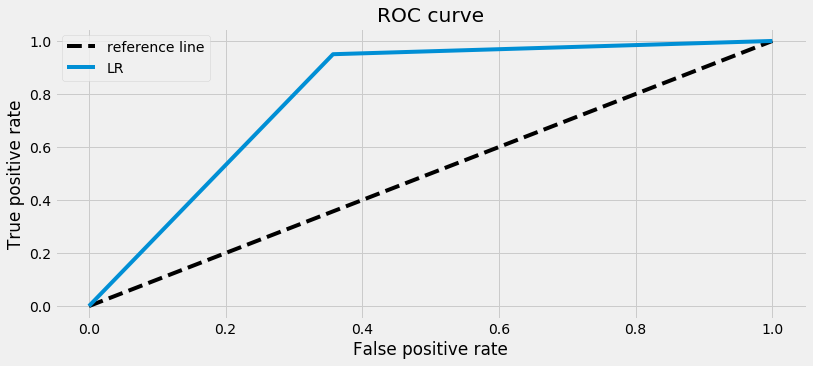

0.7964285714285713


In [477]:
AUC_score = roc_curve_plot(test_labels, y_pred_clf_kbest, legend = 'LR')
print(AUC_score)

In [478]:
#Random forest classification.
classifier_forest_kbest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_forest_kbest.fit(selectk_train_300, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [479]:
rf_kbest_cv_scores = cross_val_score(classifier_forest_kbest, selectk_train_300, train_labels, cv=5)
rf_kbest_cv_scores

array([1.        , 0.875     , 0.875     , 0.85714286, 0.85714286])

In [480]:
# Model Evaluation metrics 
y_pred_rf_kbest = classifier_forest_kbest.predict(selectk_test_300)

#accuracy_rf_kbest = (accuracy_score(test_labels,y_pred_rf_kbest))
print('Accuracy Score : ' + str(accuracy_score(test_labels,y_pred_rf_kbest)))
print('Precision Score : ' + str(precision_score(test_labels,y_pred_rf_kbest)))
print('Recall Score : ' + str(recall_score(test_labels,y_pred_rf_kbest)))
print('F1 Score : ' + str(f1_score(test_labels,y_pred_rf_kbest)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,y_pred_rf_kbest)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.8823529411764706
Precision Score : 0.8333333333333334
Recall Score : 1.0
F1 Score : 0.9090909090909091
Confusion Matrix CLF : 
[[10  4]
 [ 0 20]]


In [13]:
#ys = 1*(test_labels == y_pred_rf_kbest)
#ys

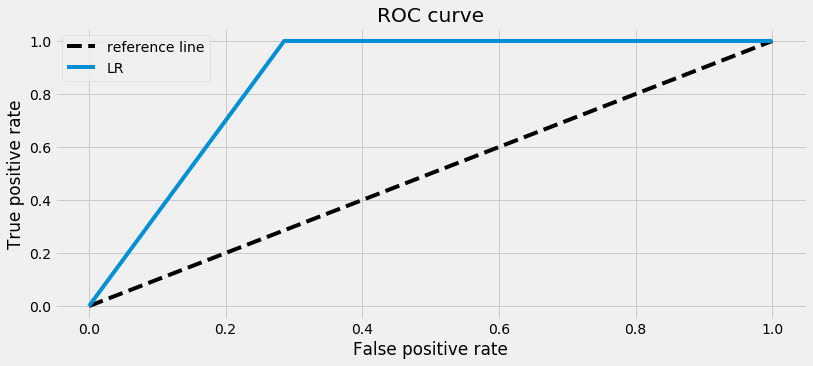

0.8571428571428572


In [481]:
AUC_score = roc_curve_plot(test_labels, y_pred_rf_kbest, legend = 'LR')
print(AUC_score)

### Select another value for SelectKBest

In [482]:
bestfeatures_2 = SelectKBest(score_func = chi2, k=50)
fit_2 = bestfeatures_2.fit(select_features, select_labels)

dfscores_2 = pd.DataFrame(fit_2.scores_)
dfcolumns_2 = pd.DataFrame(scaled_train.columns)

# concat two dataframes for better visualization 
featureScores_2 = pd.concat([dfcolumns_2, dfscores_2],axis=1)
featureScores_2.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores_2.nlargest(1000,'Score'))  #print best features
selected_chi2_2 = featureScores.nlargest(1000,'Score').Specs

                 Specs     Score
6200       Y00787_s_at  9.128844
6199  M28130_rna1_s_at  8.919277
1881         M27891_at  8.641237
2287         M84526_at  8.480393
2042         M57710_at  8.353831
...                ...       ...
359          D31763_at  0.802070
3201         U43083_at  0.801393
6078       U59632_s_at  0.800342
3224         U43965_at  0.799287
3076         U34044_at  0.799268

[1000 rows x 2 columns]


In [212]:
less_than_2 = featureScores[featureScores['Score'] > 0.5].count() #Selected those above Score 0.5 for the models.
less_than_2 #use this number in the cell above 

Specs    1641
Score    1641
dtype: int64

In [483]:
mask_2 = bestfeatures_2.get_support()
selectk_features_2 = scaled_train.columns[mask_2] 
len(selectk_features_2)

50

In [485]:
list_skb_50 = list(selectk_features_2)
len(list_skb_50)

50

### Logistic Regression and Random Forest Model after SelectKBest 


In [486]:
selectk_train_50 = scaled_train[list_skb_50]
selectk_test_50 = scaled_test[list_skb_50]

In [487]:
len(selectk_train_50.columns)

50

In [488]:
clf_kbest_2 = LogisticRegression(dual=False, max_iter=1000).fit(selectk_train_50, train_labels)
y_pred_clf_kbest_2 = clf_kbest_2.predict(selectk_test_50)

In [489]:
clf_kbest_cv_scores_2 = cross_val_score(clf_kbest_2, selectk_train_50, train_labels, cv=5)
clf_kbest_cv_scores_2

array([1.        , 1.        , 1.        , 0.85714286, 1.        ])

In [490]:
# Model Evaluation metrics 

print('Accuracy Score : ' + str(accuracy_score(test_labels,y_pred_clf_kbest_2)))
print('Precision Score : ' + str(precision_score(test_labels,y_pred_clf_kbest_2)))
print('Recall Score : ' + str(recall_score(test_labels,y_pred_clf_kbest_2)))
print('F1 Score : ' + str(f1_score(test_labels,y_pred_clf_kbest_2)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,y_pred_clf_kbest_2)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.9117647058823529
Precision Score : 0.8695652173913043
Recall Score : 1.0
F1 Score : 0.9302325581395349
Confusion Matrix CLF : 
[[11  3]
 [ 0 20]]


In [14]:
#ys = 1*(test_labels == y_pred_clf_kbest_2)
#ys

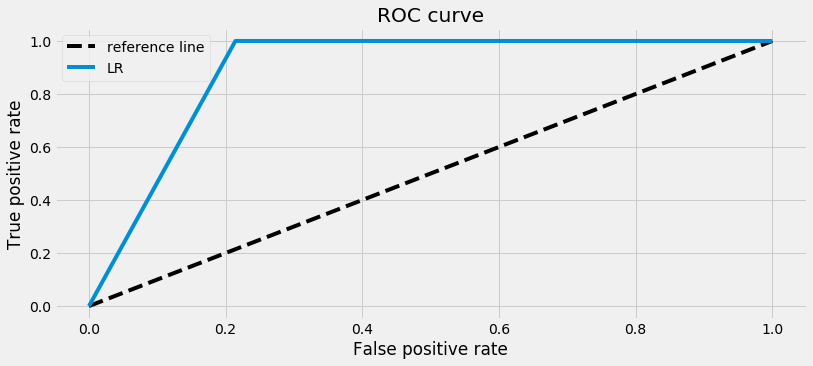

0.8928571428571428


In [491]:
AUC_score = roc_curve_plot(test_labels, y_pred_clf_kbest_2, legend = 'LR')
print(AUC_score)

In [492]:
#Random forest classification.
classifier_forest_kbest_2 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_forest_kbest_2.fit(selectk_train_50, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [493]:
rf_kbest_cv_scores_2 = cross_val_score(classifier_forest_kbest_2, selectk_train_50, train_labels, cv=5)
rf_kbest_cv_scores_2

array([0.875     , 1.        , 0.875     , 0.85714286, 1.        ])

In [494]:
# Model Evaluation metrics 
y_pred_rf_kbest_2 = classifier_forest_kbest_2.predict(selectk_test_50)

#accuracy_rf_kbest = (accuracy_score(test_labels,y_pred_rf_kbest))
print('Accuracy Score : ' + str(accuracy_score(test_labels,y_pred_rf_kbest_2)))
print('Precision Score : ' + str(precision_score(test_labels,y_pred_rf_kbest_2)))
print('Recall Score : ' + str(recall_score(test_labels,y_pred_rf_kbest_2)))
print('F1 Score : ' + str(f1_score(test_labels,y_pred_rf_kbest_2)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,y_pred_rf_kbest_2)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.8823529411764706
Precision Score : 0.8333333333333334
Recall Score : 1.0
F1 Score : 0.9090909090909091
Confusion Matrix CLF : 
[[10  4]
 [ 0 20]]


In [15]:
#ys = 1*(test_labels == y_pred_rf_kbest_2)
#ys

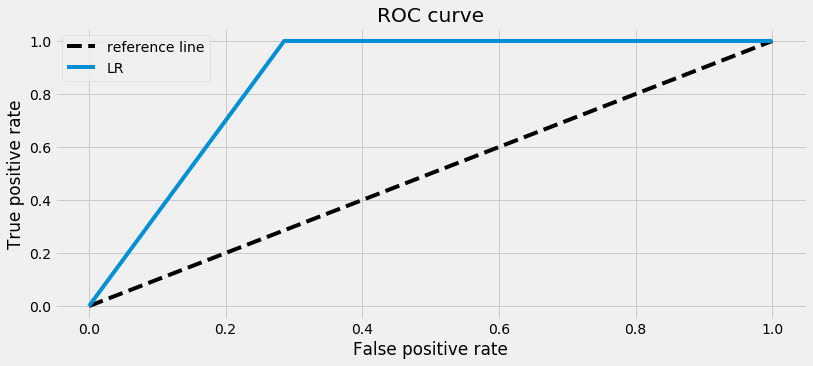

0.8571428571428572


In [495]:
AUC_score = roc_curve_plot(test_labels, y_pred_rf_kbest_2, legend = 'LR')
print(AUC_score)

### 

In [355]:
bestfeatures_3 = SelectKBest(score_func = chi2, k=300)
fit_3 = bestfeatures_3.fit(select_features, select_labels)

dfscores_3 = pd.DataFrame(fit_2.scores_)
dfcolumns_3 = pd.DataFrame(scaled_train.columns)

#concat two dataframes for better visualization 
featureScores_3 = pd.concat([dfcolumns_3, dfscores_3],axis=1)
featureScores_3.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores_3.nlargest(1000,'Score'))  #print best features
selected_chi2_3 = featureScores.nlargest(1000,'Score').Specs

                 Specs     Score
6200       Y00787_s_at  9.128844
6199  M28130_rna1_s_at  8.919277
1881         M27891_at  8.641237
2287         M84526_at  8.480393
2042         M57710_at  8.353831
...                ...       ...
359          D31763_at  0.802070
3201         U43083_at  0.801393
6078       U59632_s_at  0.800342
3224         U43965_at  0.799287
3076         U34044_at  0.799268

[1000 rows x 2 columns]


In [356]:
mask_3 = bestfeatures_3.get_support()
selectk_features_3 = scaled_train.columns[mask_3] 
len(selectk_features_3)

300

In [357]:
list_skb_3 = list(selectk_features_3)

In [690]:
from sklearn.feature_selection import f_classif


### Check feature importance with the feature_importance_ attribute of tree-based models
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [226]:
#scaled_train, train_labels
#scaled_test, test_labels

In [496]:
#Random forest classification.
classifier_forest_00 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_forest_00.fit(scaled_train, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [17]:
# Get numerical feature importances
#importances_cf_00 = list(classifier_forest_00.feature_importances_)

#feature_list_00 = list(scaled_train.columns)
# List of tuples with variable and importance
#feature_importances_cf_00 = [(feature, round(importance, 2)) for feature, importance in zip(feature_list_00, importances_cf_00)]

# Sort the feature importances by most important first
#feature_importances_cf_00 = sorted(feature_importances_cf_00, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
#[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_cf_00];

In [498]:
len(feature_importances_cf_00)

7129

In [499]:
#How many features have importance higher than 0.0. Based on feature_importances attribute, only 19?
count = 0
for t in feature_importances_cf_00:
    if 0.00 in t:
        count +=1
print(count)
        

7110


In [ ]:
#Get the set of the features

In [18]:
#importances_cf
# indices_cf_00 = np.argsort(importances_cf_00)[::-1]
# for f in range(scaled_train.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices_cf_00[f], importances_cf_00[indices_cf_00[f]]))

In [501]:
scaled_train.shape[1]

7129

In [502]:
# 300 features
c = 0
best_of_cf_300 = []
while c < 300:
    best_of_cf_300.append(indices_cf_00[c])
    c += 1
len(best_of_cf_300)

300

In [503]:
new_train_features_cf = scaled_train.iloc[:,best_of_cf_300]
new_test_features_cf = scaled_test.iloc[:, best_of_cf_300]

best_of_cf_list = list(new_test_features_cf.columns)

### Logistic Regression and Random forest with the set of the features from the feature_importance_ attribute

In [653]:
clf_red = LogisticRegression(dual=False, max_iter=1000).fit(new_train_features_cf, train_labels)
clf_pred_red_300 = clf_red.predict(new_test_features_cf)

In [654]:
clf_red_scores = cross_val_score(clf_red, new_train_features_cf, train_labels, cv=5)
clf_red_scores

array([0.875     , 1.        , 1.        , 0.85714286, 1.        ])

In [655]:
# Model Evaluation metrics 

print('Accuracy Score : ' + str(accuracy_score(test_labels,clf_pred_red_300)))
print('Precision Score : ' + str(precision_score(test_labels,clf_pred_red_300)))
print('Recall Score : ' + str(recall_score(test_labels,clf_pred_red_300)))
print('F1 Score : ' + str(f1_score(test_labels,clf_pred_red_300)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,clf_pred_red_300)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.8235294117647058
Precision Score : 0.7692307692307693
Recall Score : 1.0
F1 Score : 0.8695652173913044
Confusion Matrix CLF : 
[[ 8  6]
 [ 0 20]]


In [19]:
#ys = 1*(test_labels == clf_pred_red_300)
#ys

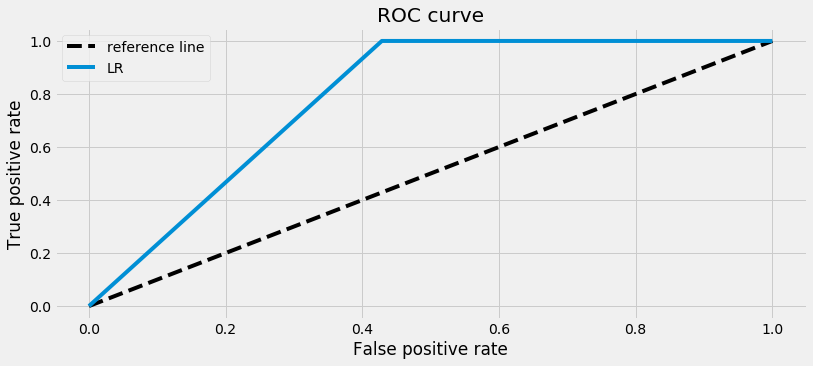

0.7857142857142857


In [507]:
AUC_score = roc_curve_plot(test_labels, clf_pred_red, legend = 'LR')
print(AUC_score)

In [243]:
#Rebuild andom forest classifier with the new reduced feature set

In [657]:
classifier_forest_red = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_forest_red.fit(new_train_features_cf, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [658]:
rfred_cv_scores = cross_val_score(classifier_forest_red, new_train_features_cf, train_labels, cv=5)
rfred_cv_scores

array([0.75      , 1.        , 0.875     , 0.85714286, 1.        ])

In [659]:
# Model Evaluation metrics 
y_pred_rf_red = classifier_forest_red.predict(new_test_features_cf)

print('Accuracy Score : ' + str(accuracy_score(test_labels,y_pred_rf_red)))
print('Precision Score : ' + str(precision_score(test_labels,y_pred_rf_red)))
print('Recall Score : ' + str(recall_score(test_labels,y_pred_rf_red)))
print('F1 Score : ' + str(f1_score(test_labels,y_pred_rf_red)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,y_pred_rf_red)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.8529411764705882
Precision Score : 0.8
Recall Score : 1.0
F1 Score : 0.888888888888889
Confusion Matrix CLF : 
[[ 9  5]
 [ 0 20]]


In [20]:
#ys = 1*(test_labels == y_pred_rf_red)
#ys

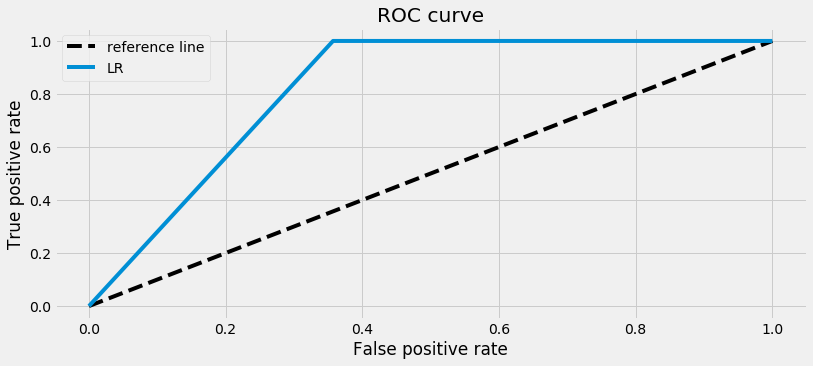

0.8214285714285714


In [511]:
AUC_score = roc_curve_plot(test_labels, y_pred_rf_red, legend = 'LR')
print(AUC_score)

In [512]:
# With 50 features from feature_importance_ 

In [513]:
c_2 = 0
best_of_cf_50 = []
while c_2 < 50:
    best_of_cf_50.append(indices_cf_00[c_2])
    c_2 += 1
len(best_of_cf_50)

50

In [514]:
new_train_features_50 = scaled_train.iloc[:,best_of_cf_50]
new_test_features_50 = scaled_test.iloc[:, best_of_cf_50]

best_of_cf_list_50 = list(new_test_features_50.columns)

In [661]:
clf_red = LogisticRegression(dual=False, max_iter=1000).fit(new_train_features_50, train_labels)
clf_pred_red_50 = clf_red.predict(new_test_features_50)

In [516]:
clf_red_scores = cross_val_score(clf_red, new_train_features_50, train_labels, cv=5)
clf_red_scores

array([1.        , 1.        , 1.        , 0.85714286, 1.        ])

In [662]:
print('Accuracy Score : ' + str(accuracy_score(test_labels,clf_pred_red_50)))
print('Precision Score : ' + str(precision_score(test_labels,clf_pred_red_50)))
print('Recall Score : ' + str(recall_score(test_labels,clf_pred_red_50)))
print('F1 Score : ' + str(f1_score(test_labels,clf_pred_red_50)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,clf_pred_red_50)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.8823529411764706
Precision Score : 0.8333333333333334
Recall Score : 1.0
F1 Score : 0.9090909090909091
Confusion Matrix CLF : 
[[10  4]
 [ 0 20]]


In [21]:
#ys = 1*(test_labels == clf_pred_red_50)
#ys

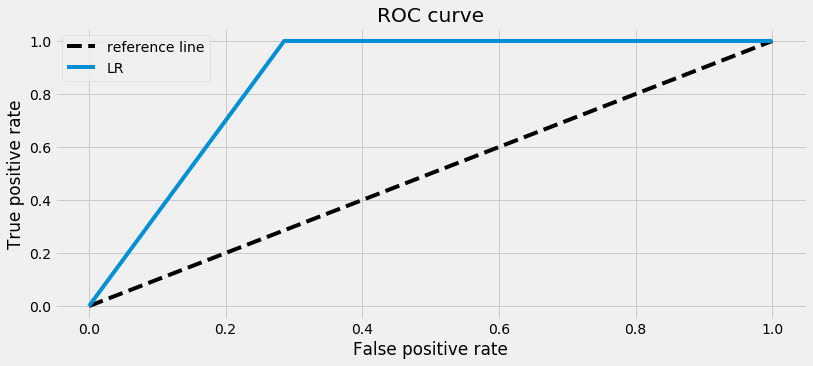

0.8571428571428572


In [518]:
AUC_score = roc_curve_plot(test_labels, clf_pred_red, legend = 'LR')
print(AUC_score)

In [665]:
classifier_forest_red_50 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_forest_red_50.fit(new_train_features_50, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [520]:
rfred_cv_scores = cross_val_score(classifier_forest_red, new_train_features_50, train_labels, cv=5)
rfred_cv_scores

array([1.   , 0.875, 0.875, 1.   , 1.   ])

In [666]:
# Model Evaluation metrics 
y_pred_rf_red_50 = classifier_forest_red_50.predict(new_test_features_50)

print('Accuracy Score : ' + str(accuracy_score(test_labels,y_pred_rf_red_50)))
print('Precision Score : ' + str(precision_score(test_labels,y_pred_rf_red_50)))
print('Recall Score : ' + str(recall_score(test_labels,y_pred_rf_red_50)))
print('F1 Score : ' + str(f1_score(test_labels,y_pred_rf_red_50)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,y_pred_rf_red_50)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.8235294117647058
Precision Score : 0.85
Recall Score : 0.85
F1 Score : 0.85
Confusion Matrix CLF : 
[[11  3]
 [ 3 17]]


In [23]:
#ys = 1*(test_labels == y_pred_rf_red_50)
#ys

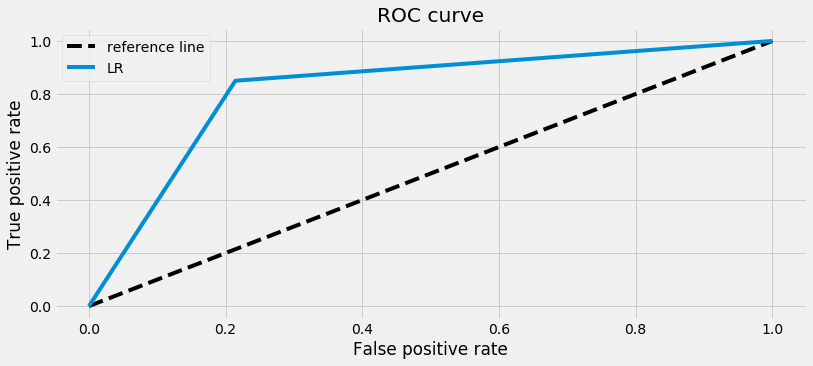

0.8178571428571428


In [523]:
AUC_score = roc_curve_plot(test_labels, y_pred_rf_red, legend = 'LR')
print(AUC_score)

## Check with the Golub 50 features

In [ ]:
#The genes from the paper
genes_all = ['U22376', 'X59417', 'U05259', 'M92287', 'M31211',  'X74262', 'D26156', 'S50223', 
       'M31523', 'L47738', 'U32944', 'Z15115', 'X15949', 'X63469', 'M91432', 'U29175', 
       'Z69881', 'U20998', 'D38073', 'U26266', 'M31303', 'Y08612', 'U35451', 'M29696', 'M13792']

In [ ]:
genes_alm = ['M55150', 'X95735', 'U50136', 'M16038', 'U82759', 'M23197', 'M84526', 'Y12670',
             'M27891', 'X17042', 'Y00787', 'M96326', 'U46751', 'M80254', 'L08246', 'M62762',
             'M28130', 'M63138', 'M57710', 'M69043', 'M81695', 'X85116', 'M19045', 'M83652', 'X04085']

In [524]:
genes_combined = genes_all + genes_alm
len(genes_combined), type(genes_combined)

(50, list)

In [525]:
scaled_list = scaled_train.columns.tolist()

In [545]:
#scaled_columns
sep_1 = "['"
sep_2 = '_'
scaled_columns_list = []
for gene in scaled_list:
    #rest = gene.split(sep_1, 1)[0]
    rest_2 = gene.split(sep_2, 1)[0]
    scaled_columns_list.append(rest_2)
print(len(scaled_columns_list))

7129


In [546]:
scaled_train_g = scaled_train.copy()
scaled_test_g = scaled_test.copy()
scaled_train_g.shape

(38, 7129)

In [547]:
#df.columns = New_Labels
scaled_train_g.columns = scaled_columns_list
scaled_test_g.columns = scaled_columns_list

In [548]:
scaled_train_g.columns

Index(['AFFX-BioB-5', 'AFFX-BioB-M', 'AFFX-BioB-3', 'AFFX-BioC-5',
       'AFFX-BioC-3', 'AFFX-BioDn-5', 'AFFX-BioDn-3', 'AFFX-CreX-5',
       'AFFX-CreX-3', 'AFFX-BioB-5',
       ...
       'U48730', 'U58516', 'U73738', 'X06956', 'X16699', 'X83863', 'Z17240',
       'L49218', 'M71243', 'Z78285'],
      dtype='object', length=7129)

In [549]:
golub_train = scaled_train_g[genes_combined]
golub_test = scaled_test_g[genes_combined]

In [550]:
## Models with Golub genes

In [551]:
clf_golub = LogisticRegression(dual=False, max_iter=1000).fit(golub_train, train_labels)
y_pred_golub = clf_golub.predict(golub_test)

In [552]:
print('Accuracy Score : ' + str(accuracy_score(test_labels,y_pred_golub)))
print('Precision Score : ' + str(precision_score(test_labels,y_pred_golub)))
print('Recall Score : ' + str(recall_score(test_labels,y_pred_golub)))
print('F1 Score : ' + str(f1_score(test_labels,y_pred_golub)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,y_pred_golub)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.8823529411764706
Precision Score : 0.8333333333333334
Recall Score : 1.0
F1 Score : 0.9090909090909091
Confusion Matrix CLF : 
[[10  4]
 [ 0 20]]


In [24]:
#ys = 1*(test_labels == y_pred_golub)
#ys

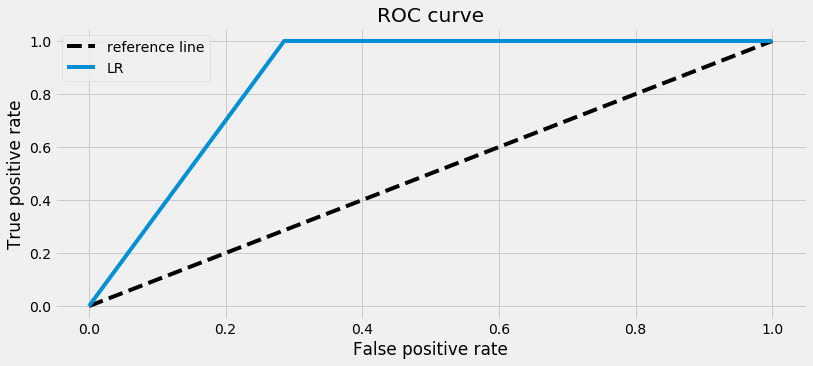

0.8571428571428572


In [553]:
AUC_score = roc_curve_plot(test_labels, y_pred_golub, legend = 'LR')
print(AUC_score)

In [554]:
classifier_forest_golub = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_forest_golub.fit(golub_train, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [555]:
# Model Evaluation metrics 
y_pred_rf_golub = classifier_forest_golub.predict(golub_test)

print('Accuracy Score : ' + str(accuracy_score(test_labels,y_pred_rf_golub)))
print('Precision Score : ' + str(precision_score(test_labels,y_pred_rf_golub)))
print('Recall Score : ' + str(recall_score(test_labels,y_pred_rf_golub)))
print('F1 Score : ' + str(f1_score(test_labels,y_pred_rf_golub)))

#Confusion matrix
print('Confusion Matrix CLF : \n' + str(confusion_matrix(test_labels,y_pred_rf_golub)))
#true neg, false pos
#false neg, true pos

Accuracy Score : 0.9705882352941176
Precision Score : 0.9523809523809523
Recall Score : 1.0
F1 Score : 0.975609756097561
Confusion Matrix CLF : 
[[13  1]
 [ 0 20]]


In [670]:
test_labels

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    0
12    0
13    0
14    0
15    0
16    1
17    1
18    0
19    0
20    1
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    1
29    1
30    1
31    1
32    1
33    1
Name: cancer, dtype: int64

In [25]:
#ys = 1*(test_labels == y_pred_rf_golub)
#ys

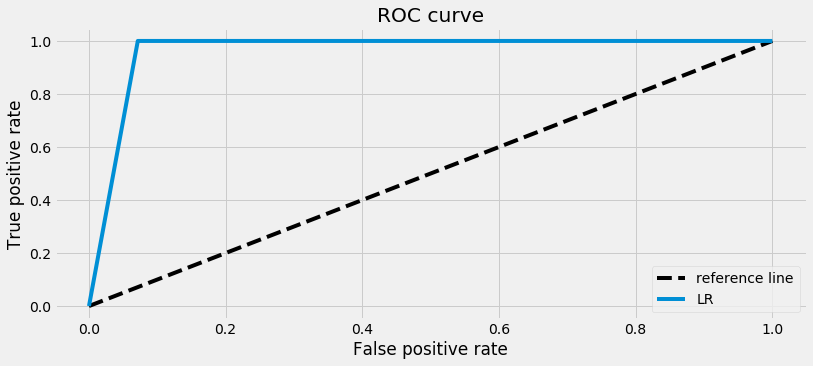

0.9642857142857143


In [556]:
AUC_score = roc_curve_plot(test_labels, y_pred_rf_golub, legend = 'LR')
print(AUC_score)

### Let's compare the lists of genes we generated from the methods

In [247]:
# SelectKBest (300): list_skb_300
# SelectKBest (50): list_skb_50

# RFE (300): rfecv_list
# RFE (50): rfecv_list_50

# RFE (300): rfe_2_list
# RFE (50): rfe_2_list_50


# feature_importance_ (300): best_of_cf_list
# feature_importance_ (50): best_of_cf_list_50


#### Clean all the lists 

In [558]:
#list_skb_300
sep = '_'
list_skb_clean_300 = []
for gene in list_skb_300:
    rest = gene.split(sep, 1)[0]
    list_skb_clean_300.append(rest)
print(len(list_skb_clean_300))

300


In [559]:
bb_1 = [item for item in list_skb_clean_300 if item in genes_all]
bb_2 = [item for item in list_skb_clean_300 if item in genes_alm]
print(len(bb_1), len(bb_2), len(list_skb_clean_300))

24 25 300


In [560]:
#list_skb_50

list_skb_clean_50 = []
for gene in list_skb_50:
    rest = gene.split(sep, 1)[0]
    list_skb_clean_50.append(rest)
print(len(list_skb_clean_50))

50


In [563]:
bc_1 = [item for item in list_skb_clean_50 if item in genes_all]
bc_2 = [item for item in list_skb_clean_50 if item in genes_alm]
print(len(bc_1), len(bc_2), len(list_skb_clean_50))

0 19 50


In [564]:
#rfecv_list

rfecv_list_clean_300 = []
for gene in rfecv_list:
    rest = gene.split(sep, 1)[0]
    rfecv_list_clean_300.append(rest)
print(len(rfecv_list_clean_300))

300


In [572]:
bc_1 = [item for item in scaled_columns_list if item in list_skb_clean_50]
print(len(bc_1))

50


In [565]:
bca_1 = [item for item in rfecv_list_clean_300 if item in genes_all]
bca_2 = [item for item in rfecv_list_clean_300 if item in genes_alm]
print(len(bca_1), len(bca_2), len(rfecv_list_clean_300))

0 0 300


In [567]:
#rfecv_list_50

rfecv_list_clean_50 = []
for gene in rfecv_list_50:
    rest = gene.split(sep, 1)[0]
    rfecv_list_clean_50.append(rest)
print(len(rfecv_list_clean_50))

50


In [568]:
bca_1 = [item for item in rfecv_list_clean_50 if item in genes_all]
bca_2 = [item for item in rfecv_list_clean_50 if item in genes_alm]
print(len(bca_1), len(bca_2), len(rfecv_list_clean_50))

0 0 50


In [573]:
#rfe_2_list
rfe_2_list_clean_300 = []
for gene in rfe_2_list:
    rest = gene.split(sep, 1)[0]
    rfe_2_list_clean_300.append(rest)
print(len(rfe_2_list_clean_300))

300


In [685]:
bcc_1 = [item for item in rfe_2_list_clean_300 if item in genes_all]
bcc_2 = [item for item in rfe_2_list_clean_300 if item in genes_alm]
print(len(bcc_1), len(bcc_2), len(rfe_2_list_clean_300))

13 25 300


In [ ]:
#Overlap between the two sets of 300 genes and 50 & 50.
bcc_1 = [item for item in rfe_2_list_clean_300 if item in list_skb_clean_300]
bcc_2 = [item for item in rfe_2_list_clean_300 if item in list_skb_clean_300 and item in genes_combined]
bcc_3 = [item for item in list_skb_clean_50 if item in rfe_2_list_clean_50 and item in genes_combined]
bcc_4 = [item for item in list_skb_clean_50 if item in rfe_2_list_clean_50]
print(len(bcc_1), len(bcc_2), len(bcc_3), len(bcc_4))

In [681]:
from matplotlib_venn import venn2


In [697]:
#venn2([set(bcc_2), set(rfe_2_list_clean_300)])

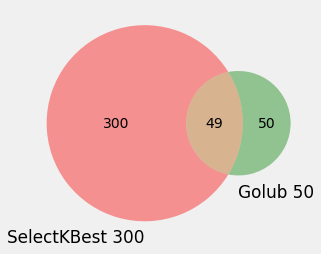

In [693]:
venn2(subsets = (300, 50, 49), set_labels = ('SelectKBest 300', 'Golub 50'))
plt.show()


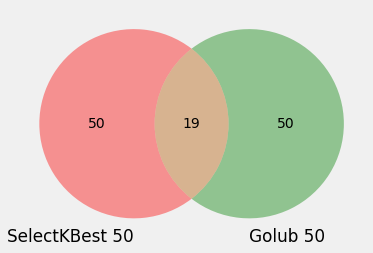

In [695]:
venn2(subsets = (50, 50, 19), set_labels = ('SelectKBest 50', 'Golub 50'))
plt.show()


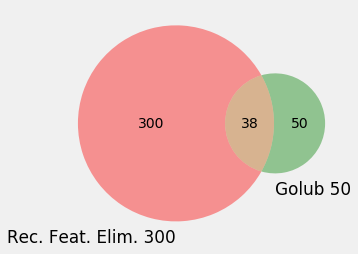

In [696]:
venn2(subsets = (300, 50, 38), set_labels = ('Rec. Feat. Elim. 300', 'Golub 50'))
plt.show()

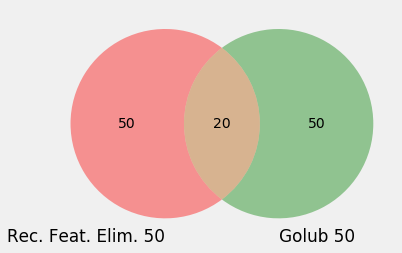

In [698]:
venn2(subsets = (50, 50, 20), set_labels = ('Rec. Feat. Elim. 50', 'Golub 50'))
plt.show()

In [575]:
#rfe_2_list_50
rfe_2_list_clean_50 = []
for gene in rfe_2_list_50:
    rest = gene.split(sep, 1)[0]
    rfe_2_list_clean_50.append(rest)
print(len(rfe_2_list_clean_50))

50


In [590]:
bcc_1 = [item for item in rfe_2_list_clean_50 if item in genes_all]
bcc_2 = [item for item in rfe_2_list_clean_50 if item in genes_alm]
print((bcc_1), len(bcc_2), len(rfe_2_list_clean_50))

['U22376'] 19 50


In [583]:
#best_of_cf_300

best_of_cf_clean_300 = []
for gene in best_of_cf_list:
    #rest = gene.split(sep_1, 1)[1]
    rest_2 = gene.split(sep_2, 1)[0]
    best_of_cf_clean_300.append(rest_2)
print(len(best_of_cf_clean_300))

300


In [591]:
bcc_1 = [item for item in best_of_cf_clean_300 if item in genes_all]
bcc_2 = [item for item in best_of_cf_clean_300 if item in genes_alm]
print((bcc_1), len(bcc_2), len(best_of_cf_clean_300))

['M91432', 'M92287', 'S50223', 'U05259'] 4 300


In [585]:
#best_of_cf_list_50

best_of_cf_clean_50 = []
for gene in best_of_cf_list_50:
    #rest = gene.split(sep_1, 1)[1]
    rest_2 = gene.split(sep_2, 1)[0]
    best_of_cf_clean_50.append(rest_2)
print(len(best_of_cf_clean_50))

50


In [593]:
bcc_11 = [item for item in best_of_cf_clean_50 if item in genes_all]
bcc_22 = [item for item in best_of_cf_clean_50 if item in genes_alm]
print((bcc_11), (bcc_22), len(best_of_cf_clean_50))

['M91432', 'M92287'] ['M27891'] 50


In [606]:
#Lists to set:
all_lists = [list_skb_clean_300, list_skb_clean_50, rfecv_list_clean_300, rfecv_list_clean_50, 
             rfe_2_list_clean_300, rfe_2_list_clean_50, best_of_cf_clean_300, best_of_cf_clean_50]

lists_300 = [list_skb_clean_300, rfecv_list_clean_300, rfe_2_list_clean_300, best_of_cf_clean_300]
lists_50 = [list_skb_clean_50, rfecv_list_clean_50, rfe_2_list_clean_50, best_of_cf_clean_50]

sets_300 = []
for lst in lists_300:
    sets_300.append(set(lst))
    
lists_300_b = [list_skb_clean_300, best_of_cf_clean_300]
sets_300_b = []
for lst in lists_300_b:
    sets_300_b.append(set(lst))
    
sets_50 = []
for lst in lists_50:
    sets_50.append(set(lst))
        
    
#set(d[0]).intersection(*d)

In [614]:
matching = (sets_300_b[0]).intersection(*sets_300_b)
len(matching)

23